# Imports and functions

In [6]:
from datetime import datetime
print(datetime.now())
#data preprocessing
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import collections
from collections import defaultdict
# NN
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import math
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, roc_auc_score, auc, accuracy_score
from sklearn.metrics import average_precision_score
import sklearn.metrics as metrics
from sklearn.impute import SimpleImputer
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from matplotlib import pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients
from tqdm import tqdm


# the full files pathes are here
DATA_PATH_stages="data/kdigo_stages_measured.csv" 
DATA_PATH_labs = "data/labs-kdigo_stages_measured.csv" 
DATA_PATH_vitals = "data/vitals-kdigo_stages_measured.csv" 
DATA_PATH_vents = "data/vents-vasopressor-sedatives-kdigo_stages_measured.csv"
DATA_PATH_detail="data/icustay_detail-kdigo_stages_measured.csv" 
SEPARATOR=";"

2024-05-31 18:18:13.354193


In [7]:
import torch

if (torch.cuda.is_available()):
    print('Training on GPU')
else:
    print('Training on CPU') # On mac book GPU is not possible =() 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Training on GPU


In [8]:
IMPUTE_EACH_ID = False # imputation within each icustay_id with most common value
IMPUTE_COLUMN = False # imputation based on whole column

In [9]:
# Set parameter as constant 

TESTING = False 
TEST_SIZE = 0.05

SPLIT_SIZE = 0.2 
MAX_DAYS = 35

#which classifier to use, only run one classifier at one time 
CLASS1 = True   #AnyAKI
#CLASS2 = False    #ModerateSevereAKI
#CLASS3 = False    #SevereAKI
ALL_STAGES = False # not binary label, each class separately 0,1,2,3
    
MAX_FEATURE_SET = True
#DIAGNOSIS = False

FIRST_TURN_POS = True # creating one label per one ICU stay id

# resampling  and imputing
TIME_SAMPLING = True 
SAMPLING_INTERVAL = '6H'
RESAMPLE_LIMIT = 16 # 4 days*6h interval
MOST_COMMON = False #resampling with most common
# if MOST_COMMON is not applied,sampling with different strategies per kind of variable, 
# numeric variables use mean value, categorical variables use max value

IMPUTE_METHOD = 'most_frequent' 
FILL_VALUE = 0 #fill missing value and ragged part of 3d array

#Age constraints: adults
ADULTS_MIN_AGE = 18
ADULTS_MAX_AGE = 120

NORMALIZATION = 'min-max' 

CAPPING_THRESHOLD_UPPER = 0.99
CAPPING_THRESHOLD_LOWER = 0.01

# How much time the prediction should occur (hours)
HOURS_AHEAD = 48

NORM_TYPE = 'min_max'

RANDOM = 42

#set changable info corresponding to each classifier as variables

min_set =  ["icustay_id", "charttime", "creat", "uo_rt_6hr", "uo_rt_12hr", "uo_rt_24hr", "aki_stage"]

max_set = ['icustay_id', 'charttime', 'aki_stage', 'hadm_id','aniongap_avg', 'bicarbonate_avg', 
           'bun_avg','chloride_avg', 'creat', 'diasbp_mean', 'glucose_avg', 'heartrate_mean',
           'hematocrit_avg', 'hemoglobin_avg', 'potassium_avg', 'resprate_mean','sodium_avg', 'spo2_mean', 'sysbp_mean', 
           'uo_rt_12hr', 'uo_rt_24hr','uo_rt_6hr', 'wbc_avg', 'sedative', 'vasopressor', 'vent', 'age', 'F','M', 
           'asian', 'black', 'hispanic', 'native', 'other', 'unknown','white', 'ELECTIVE', 'EMERGENCY', 'URGENT']

# LSTM
batch_size = 5

# naming model and plot
classifier_name = "None vs. Any AKI"    ###change every time #Moderate vs. Severe #None vs. Any #Others vs. Severe
plot_name = "adult_AnyAKI_LR"    ###change every time

In [10]:
# Some functions used later

def cap_data(df):
    print("Capping between the {} and {} quantile".format(CAPPING_THRESHOLD_LOWER, CAPPING_THRESHOLD_UPPER))
    cap_mask = df.columns.difference(['icustay_id', 'charttime', 'aki_stage'])
    df[cap_mask] = df[cap_mask].clip(df[cap_mask].quantile(CAPPING_THRESHOLD_LOWER),
                                     df[cap_mask].quantile(CAPPING_THRESHOLD_UPPER),
                                     axis=1)

    return df
 
    
def normalise_data(df, norm_mask):
    print("Normalizing in [0,1] with {} normalization".format(NORMALIZATION))
    
    df[norm_mask] = (df[norm_mask] - df[norm_mask].min()) / (df[norm_mask].max() - df[norm_mask].min())
    
    return df


# impute missing value in resampleing data with most common based on each id
def fast_mode(df, key_cols, value_col):
    """ Calculate a column mode, by group, ignoring null values. 
    
    key_cols : list of str - Columns to groupby for calculation of mode.
    value_col : str - Column for which to calculate the mode. 

    Return
    pandas.DataFrame
        One row for the mode of value_col per key_cols group. If ties, returns the one which is sorted first. """
    return (df.groupby(key_cols + [value_col]).size() 
              .to_frame('counts').reset_index() 
              .sort_values('counts', ascending=False) 
              .drop_duplicates(subset=key_cols)).drop('counts',axis=1)


#get max shape of 3d array
def get_dimensions(array, level=0):   
    yield level, len(array)
    try:
        for row in array:
            yield from get_dimensions(row, level + 1)
    except TypeError: #not an iterable
        pass

def get_max_shape(array):
    dimensions = defaultdict(int)
    for level, length in get_dimensions(array):
        dimensions[level] = max(dimensions[level], length)
    return [value for _, value in sorted(dimensions.items())]

#pad the ragged 3d array to rectangular shape based on max size
def iterate_nested_array(array, index=()):
    try:
        for idx, row in enumerate(array):
            yield from iterate_nested_array(row, (*index, idx)) 
    except TypeError: # final level            
        yield (*index, slice(len(array))), array # think of the types

def pad(array, fill_value):
    dimensions = get_max_shape(array)
    result = np.full(dimensions, fill_value, dtype = np.float64)  
    for index, value in iterate_nested_array(array):
        result[index] = value 
    return result

def bin_total(y_true, y_prob, n_bins):
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)

    # In sklearn.calibration.calibration_curve,
    # the last value in the array is always 0.
    binids = np.digitize(y_prob, bins) - 1

    return np.bincount(binids, minlength=len(bins))

def missing_bin(bin_array):
    midpoint = " "    
    if bin_array[0]==0:
        midpoint = "5%, "
    if bin_array[1]==0:
        midpoint = midpoint + "15%, "
    if bin_array[2]==0:
        midpoint = midpoint + "25%, "
    if bin_array[3]==0:
        midpoint = midpoint + "35%, " 
    if bin_array[4]==0:
        midpoint = midpoint + "45%, "
    if bin_array[5]==0:
        midpoint = midpoint + "55%, "
    if bin_array[6]==0:
        midpoint = midpoint + "65%, "
    if bin_array[7]==0:
        midpoint = midpoint + "75%, "
    if bin_array[8]==0:
        midpoint = midpoint + "85%, "
    if bin_array[9]==0:
        midpoint = midpoint + "95%, "
    return "The missing bins have midpoint values of "+ str(midpoint)

# Preprocessing

## Data Loading & Preprocessing

In [11]:
print("read csv files")
#reading csv files
X = pd.read_csv(DATA_PATH_stages, sep= SEPARATOR)
# print column names
print(X.columns)
# print number of rows and columns
print(X.shape)
X.drop(["aki_stage_creat", "aki_stage_uo"], axis = 1, inplace = True)
#remove totally empty rows 
X = X.dropna(how = 'all', subset = ['creat','uo_rt_6hr','uo_rt_12hr','uo_rt_24hr','aki_stage'])
print("convert charttime to timestamp")
X['charttime'] = pd.to_datetime(X['charttime'])

#merge rows if they have exact timestamp within same icustay_id AL : it substitutes missing values with zero
#X = X.groupby(['icustay_id', 'charttime']).sum().reset_index(['icustay_id', 'charttime'])

dataset_detail = pd.read_csv(DATA_PATH_detail, sep= SEPARATOR)  #age constraint
dataset_detail.drop(['dod', 'admittime','dischtime', 'los_hospital','ethnicity','hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq','first_icu_stay'], axis = 1, inplace = True)


read csv files


Index(['icustay_id', 'charttime', 'creat', 'aki_stage_creat', 'uo_rt_6hr',
       'uo_rt_12hr', 'uo_rt_24hr', 'aki_stage_uo', 'aki_stage'],
      dtype='object')
(3737147, 9)
convert charttime to timestamp


In [12]:
dataset_labs = pd.read_csv(DATA_PATH_labs, sep= SEPARATOR) # 'bands lactate platelet ptt inr pt
dataset_labs.drop(['albumin_min', 'albumin_max','bilirubin_min', 'bilirubin_max','bands_min', 'bands_max',
                   'lactate_min', 'lactate_max','platelet_min', 'platelet_max','ptt_min', 'ptt_max', 
                   'inr_min', 'inr_max', 'pt_min', 'pt_max'], axis = 1, inplace = True)
dataset_labs = dataset_labs.dropna(subset=['charttime'])
dataset_labs = dataset_labs.dropna(subset=dataset_labs.columns[4:], how='all')
dataset_labs['charttime'] = pd.to_datetime(dataset_labs['charttime'])
dataset_labs = dataset_labs.sort_values(by=['icustay_id', 'charttime'])

if  MAX_FEATURE_SET:
    dataset_vitals = pd.read_csv(DATA_PATH_vitals, sep= SEPARATOR)  
    dataset_vents = pd.read_csv(DATA_PATH_vents , sep= SEPARATOR)
    #dataset_icd = pd.read_csv(DATA_PATH_icd, sep= SEPARATOR)
    dataset_vitals.drop(["heartrate_min", "heartrate_max","sysbp_min", "sysbp_max","diasbp_min", "diasbp_max",
                        'meanbp_min','meanbp_max', 'meanbp_mean','tempc_min', 'tempc_max', 'tempc_mean',
                        "resprate_min", "resprate_max", "spo2_min", "spo2_max", "glucose_min", "glucose_max"], axis = 1, inplace = True)    
    print("convert charttime to timestamp")
    dataset_vitals['charttime'] = pd.to_datetime(dataset_vitals['charttime'])
    dataset_vents['charttime'] = pd.to_datetime(dataset_vents['charttime'])
    dataset_vitals = dataset_vitals.sort_values(by=['icustay_id', 'charttime'])
    dataset_vents = dataset_vents.sort_values(by=['icustay_id', 'charttime'])
    # AL drop those where all columns are nan (empty rows)
    dataset_vitals = dataset_vitals.dropna(subset=dataset_vitals.columns[4:], how='all')   
     

In [ ]:
print(datetime.now())
# Labs file: instead of min and max their avg
counter = 0
col1 = 4
col2 = 5
null_l = [] # no null values in those that are different
changed = 0 # 4316 records changed to avg

while counter < 11:
    row = 0
# find where min and max are different and save their row indices 
    while row < len(dataset_labs):
        a = dataset_labs.iloc[row,col1]
        b = dataset_labs.iloc[row,col2]
        if a==b or (np.isnan(a) and np.isnan(b)):
            pass
        elif a!=b:
            changed +=1
            avg = (a+b)/2
            dataset_labs.iloc[row,col1] = avg
            if (np.isnan(a) and ~np.isnan(b)) or (np.isnan(b) and ~np.isnan(a)):
                null_l.append(row)
        else:
            print(a)
            print(b)
        row +=1       
    # delete the redundant column max, update counters
    dataset_labs.drop(dataset_labs.columns[col2], axis=1, inplace = True)
    counter = counter+1
    col1 = col1+1
    col2 = col2+1

dataset_labs.columns = ['subject_id','hadm_id', 'icustay_id', 'charttime', 'aniongap_avg', 'bicarbonate_avg', 
                        'creatinine_avg', 'chloride_avg', 'glucose_avg', 'hematocrit_avg','hemoglobin_avg',
                        'potassium_avg', 'sodium_avg', 'bun_avg', 'wbc_avg']
if len(null_l)>0:
    print("null values encountered")
print(datetime.now())

In [ ]:
print("Merge creatinine and glucose.")
# merge creatinine from labs and set with labels
creat_l = dataset_labs[['icustay_id','charttime','creatinine_avg']].copy()
creat_l = creat_l.dropna(subset=['creatinine_avg'])
creat = X[['icustay_id','charttime', 'creat']].copy()
creat = creat.dropna(subset=['creat'])
creat_l = creat_l.rename(columns={"creatinine_avg": "creat"})
creat = creat._append(creat_l, ignore_index=True)
creat.drop_duplicates(inplace = True)
#delete old columns
dataset_labs.drop(["creatinine_avg"], axis = 1, inplace = True)
dataset_labs = dataset_labs.dropna(subset=dataset_labs.columns[4:], how='all')
X.drop(["creat"], axis = 1, inplace = True)
#merge new column
X = pd.merge(X, creat, on = ["icustay_id", "charttime"], sort = True, how= "outer", copy = False)

if MAX_FEATURE_SET:
    # merge glucose from vitals and labs
    glucose_v = dataset_vitals[['subject_id','hadm_id','icustay_id','charttime', 'glucose_mean']].copy()
    glucose_v = glucose_v.dropna(subset=['glucose_mean'])
    glucose = dataset_labs[['subject_id','hadm_id','icustay_id','charttime', 'glucose_avg']].copy()
    glucose = glucose.dropna(subset=['glucose_avg'])
    glucose_v = glucose_v.rename(columns={"glucose_mean": "glucose_avg"})
    glucose = glucose._append(glucose_v, ignore_index=True)
    glucose.drop_duplicates(inplace = True)
    #delete old columns
    dataset_labs.drop(["glucose_avg"], axis = 1, inplace = True)
    dataset_vitals.drop(["glucose_mean"], axis = 1, inplace = True)
    dataset_vitals = dataset_vitals.dropna(subset=dataset_vitals.columns[4:], how='all')
    #merge new column
    dataset_labs = pd.merge(dataset_labs, glucose, on = ['subject_id','hadm_id','icustay_id','charttime',], sort = True, how= "outer", copy = False)
    
dataset_labs = dataset_labs.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)

In [ ]:
print("Merging labs, vitals and vents files")
if MAX_FEATURE_SET:
    X = pd.merge(X, dataset_labs, on = ["icustay_id", "charttime"], how= "outer", copy = False)
    X = pd.merge(X, dataset_vitals, on = ["icustay_id", "charttime","subject_id", "hadm_id"], how= "outer", copy = False)
    X = pd.merge(X, dataset_vents, on = ["icustay_id", "charttime"], how= "outer", copy = False) 
    X.drop(["subject_id"], axis = 1, inplace = True) 


In [ ]:
print(dataset_detail.columns)

In [ ]:
print("start preprocessing time dependent data") 
print("Removing patients under the min age")
old_length = len(X)
dataset_detail = dataset_detail.loc[dataset_detail['admission_age'] >= ADULTS_MIN_AGE]
adults_icustay_id_list = dataset_detail['icustay_id'].unique()
X = X[X.icustay_id.isin(adults_icustay_id_list)].sort_values(by=['icustay_id'], ignore_index = True)
X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
adults_icustay_id_list = np.sort(adults_icustay_id_list)
new_length = len(X)

# print out number of patients removed
print("Number of patients removed: ", old_length - new_length)


In [ ]:
print(old_length)
print(new_length)

In [ ]:
print("drop icustay_id with time span less than 48hrs")
def more_than_HOURS_ahead(adults_icustay_id_list, X):
    drop_list = []
    los_list = [] # calculating LOS ICU based on charttime
    long_stays_id = [] # LOS longer than MAX DAYS days
    last_charttime_list = []
    seq_length = X.groupby(['icustay_id'],as_index=False).size()
    id_count = 0
    first_row_index = 0

    while id_count < len(adults_icustay_id_list):
        icustay_id = adults_icustay_id_list[id_count]
        last_row_index = first_row_index + seq_length.iloc[id_count,1]-1
        first_time = X.iat[first_row_index, X.columns.get_loc('charttime')]
        last_time = X.iat[last_row_index, X.columns.get_loc('charttime')]
        los = round(float((last_time - first_time).total_seconds()/60/60/24),4) # in days
        if los < HOURS_AHEAD/24:
            drop_list.append(icustay_id)
        else:
            los_list.append(los)
            if los > MAX_DAYS:
                long_stays_id.append(icustay_id)
                last_charttime_list.append(last_time)
        # udpate for the next icustay_id
        first_row_index = last_row_index+1
        id_count +=1
    if len(long_stays_id) != len(last_charttime_list):
        print('ERROR')
    print("%d long stays" % len(long_stays_id))
    # drop all the rows with the saved icustay_id
    print("there are %d id-s shorter than 48 hours" % len(drop_list))
    X = X[~X.icustay_id.isin(drop_list)]
    id_list = X['icustay_id'].unique()
    X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
    
    return id_list, X, long_stays_id,last_charttime_list

id_list, X, long_stays_id,last_charttime_list  = more_than_HOURS_ahead(adults_icustay_id_list, X)

long = pd.DataFrame()
long['icustay_id']  = long_stays_id
long['last_time']  = last_charttime_list

new_length = len(X)
print(new_length)

In [ ]:
# deleting rows that are not within MAX_DAYS (35) period
i = 0 # long df index
drop_long_time = []
    
while i < len(long_stays_id):
    j = 0
    all_rows = X.index[X['icustay_id'] == long.loc[i,'icustay_id']].tolist()
    while j < len(all_rows):
        time = X.iat[all_rows[j], X.columns.get_loc('charttime')]
        # if keep last MAX_DAYS 
        if (long.loc[i,'last_time'] - time).total_seconds() > MAX_DAYS*24*60*60:
            drop_long_time.append(all_rows[j])
            j +=1
        else:
            break
    i +=1       
X.drop(X.index[drop_long_time], inplace=True) 

# checking for 48h min length again
id_list, X, long_stays_id,last_charttime_list  = more_than_HOURS_ahead(id_list, X)
dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'], ignore_index = True)

new_length = len(X)
print(new_length)


In [ ]:
# For testing purpose, use small amount of data first
if TESTING:
    rest, id_list = train_test_split(id_list, test_size= TEST_SIZE, random_state=42)
    X = X[X.icustay_id.isin(id_list)].sort_values(by=['icustay_id'])
    dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'])

## Resampling , imputing

In [ ]:
if (TIME_SAMPLING and MOST_COMMON):
    print("resampling: MOST_COMMON")
    # Resample the data using assigned interval,mode() for most common
    X = X.set_index('charttime').groupby('icustay_id').resample(SAMPLING_INTERVAL).mode().reset_index()
elif TIME_SAMPLING:
    print("resampling: MEAN & ZERO")
    # Sampling with different strategies per kind of variable
    label = ['aki_stage']
    skip = ['icustay_id', 'charttime', 'aki_stage']
    if MAX_FEATURE_SET:
        discrete_feat = ['sedative', 'vasopressor', 'vent', 'hadm_id']
        skip.extend(discrete_feat)    
    # all features that are not in skip are numeric
    numeric_feat = list(X.columns.difference(skip))
    
    # Applying aggregation to features depending on their type
    X = X.set_index('charttime').groupby('icustay_id').resample(SAMPLING_INTERVAL)
    if MAX_FEATURE_SET:
        X_discrete = X[discrete_feat].max().fillna(FILL_VALUE).astype(np.int64)
    X_numeric = X[numeric_feat].mean() 
    X_label = X['aki_stage'].max()
    print("Merging sampled features")
    try:
        X = pd.concat([X_numeric, X_discrete,X_label], axis=1).reset_index()
    except:
        X = pd.concat([X_numeric,X_label], axis=1).reset_index()
print(X.shape)
#Label forward fill
X['aki_stage'] = X['aki_stage'].ffill(limit=RESAMPLE_LIMIT)

new_length = len(X) 
print(new_length)

In [ ]:
print("Imputation.")
# do imputation of label with zero if there are still missing values
X['aki_stage'] = X['aki_stage'].fillna(0)

# using most common within each icustay_id
if IMPUTE_EACH_ID:
    column_name = list(X.columns)
    column_name.remove(column_name[0]) 
    for feature in column_name:
        X.loc[X[feature].isnull(), feature] = X.icustay_id.map(fast_mode(X, ['icustay_id'], feature).set_index('icustay_id')[feature])       

# imputation based on whole column
if IMPUTE_COLUMN:
    imp = SimpleImputer(missing_values=np.nan, strategy= IMPUTE_METHOD)
    cols = list(X.columns)
    cols = cols[2:23]
    X[cols]=imp.fit_transform(X[cols])  

# If no imputation method selected or only impute each id, for the remaining nan impute direclty with FILL_VALUE
X = X.fillna(FILL_VALUE) 

In [ ]:
# print out the number of columns of X
print(len(X.columns))

In [ ]:
# more comfortable to review in this order
try:
    cols = ['icustay_id', 'charttime','aki_stage','hadm_id','aniongap_avg','bicarbonate_avg', 'bun_avg','chloride_avg',
            'creat','diasbp_mean', 'glucose_avg', 'heartrate_mean', 'hematocrit_avg','hemoglobin_avg', 
            'potassium_avg', 'resprate_mean', 'sodium_avg','spo2_mean', 'sysbp_mean', 'uo_rt_12hr', 
            'uo_rt_24hr', 'uo_rt_6hr','wbc_avg', 'sedative', 'vasopressor', 'vent' ]
    X = X[cols]
    print("success")
except:
    try:
        cols = ['icustay_id', 'charttime','aki_stage','creat','uo_rt_12hr', 'uo_rt_24hr', 'uo_rt_6hr']
        X = X[cols]
    except:
        print("error")

In [ ]:
# save the preprocessed data to csv
X.to_csv('data/preprocessed_data.csv', index=False)

In [ ]:
# load the preprocessed data
X = pd.read_csv('data/data/X1.csv')

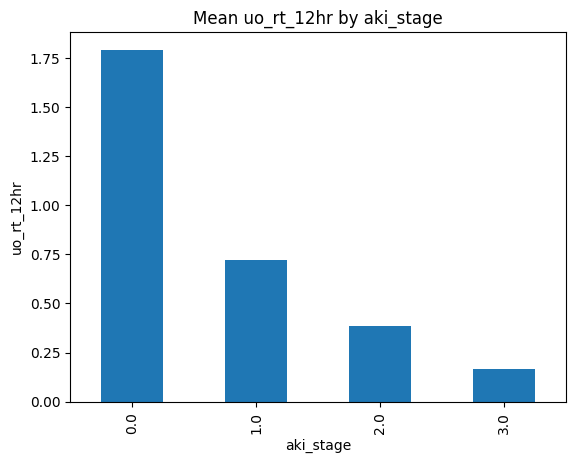

In [ ]:
col = "uo_rt_12hr"

plt.figure()
X.groupby('aki_stage')[col].mean().plot(kind='bar')
plt.ylabel(col)
plt.title(f'Mean {col} by aki_stage')
plt.savefig(f'data/analysis/{col}_by_aki_stage.png')

In [ ]:
# print headers of X
print(X.columns)

In [ ]:
print("binarise labels")
if ALL_STAGES:
    pass
elif CLASS1:
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS2:
    X.loc[X['aki_stage'] < 2, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS3:
    X.loc[X['aki_stage'] < 3, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 2, 'aki_stage'] = 1

## SHIFTING labels

In [ ]:
#print("Shifting the labels 48 h") # by 8 position : 6h sampling*8=48h and ffil 8 newly empty ones
X['aki_stage'] = X.groupby('icustay_id')['aki_stage'].shift(-(HOURS_AHEAD // int(SAMPLING_INTERVAL[:-1])))
X = X.dropna(subset=['aki_stage'])
X['icustay_id'].nunique()

## Add categorical features (details)

In [ ]:
print(dataset_detail.columns)

In [ ]:
print("start preprocessing not time dependent data")
if MAX_FEATURE_SET:
    #extract datasets based on id_list
    dataset_detail = dataset_detail.loc[dataset_detail['icustay_id'].isin(id_list)]
    #sort by ascending order
    dataset_detail = dataset_detail.sort_values(by=['icustay_id'])
    subject_id = dataset_detail["subject_id"].unique()
    #transfrom categorical data to binary form
    dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop('gender')))
    dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop("ethnicity_grouped")))
    # dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop('admission_type')))
    dataset_detail = dataset_detail.drop(['subject_id', 'hadm_id'], axis=1)
    X =  pd.merge(X, dataset_detail, on = ["icustay_id"], how= "left", copy = False) 
    numeric_feat.append('admission_age')

In [ ]:
feature_names =['Anion gap', 'Bicarbonate', 'Blood Urea Nitrogen', 'Chloride', 'Creatinine', 'Diastolic BP', 'Glucose', 'Heart rate', 
            'Hematocrit', 'Hemoglobin', 'Potassium', 'Respiratory rate', 'Sodium', 'Oxygen saturation', 'Systolic BP', 'Urine output 12h', 'Urine output 24h', 'Urine output 6h',
            'White cell count', 'Sedative', 'Vasopressor', 'Ventilation', 'Age', 'Female gender', 'Male gender', 'Asian ethnicity', 'Black ethnicity', 'Hispanic ethnicity', 'Native american', 
            'Other ethnicity', 'Ethnicity unknown', 'White ethnicity', 'Elective admission', 'Emergency admission', 'Urgent admission']



In [ ]:
X.columns

In [ ]:
print(len(X))

## Data Loading & Preprocessing

In [ ]:
print("read csv files")
#reading csv files
X = pd.read_csv(DATA_PATH_stages, sep= SEPARATOR)
# print column names
print(X.columns)
# print number of rows and columns
print(X.shape)
X.drop(["aki_stage_creat", "aki_stage_uo"], axis = 1, inplace = True)
#remove totally empty rows 
X = X.dropna(how = 'all', subset = ['creat','uo_rt_6hr','uo_rt_12hr','uo_rt_24hr','aki_stage'])
print("convert charttime to timestamp")
X['charttime'] = pd.to_datetime(X['charttime'])

#merge rows if they have exact timestamp within same icustay_id AL : it substitutes missing values with zero
#X = X.groupby(['icustay_id', 'charttime']).sum().reset_index(['icustay_id', 'charttime'])

dataset_detail = pd.read_csv(DATA_PATH_detail, sep= SEPARATOR)  #age constraint
dataset_detail.drop(['dod', 'admittime','dischtime', 'los_hospital','ethnicity','hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq','first_icu_stay'], axis = 1, inplace = True)


In [ ]:
dataset_labs = pd.read_csv(DATA_PATH_labs, sep= SEPARATOR) # 'bands lactate platelet ptt inr pt
dataset_labs.drop(['albumin_min', 'albumin_max','bilirubin_min', 'bilirubin_max','bands_min', 'bands_max',
                   'lactate_min', 'lactate_max','platelet_min', 'platelet_max','ptt_min', 'ptt_max', 
                   'inr_min', 'inr_max', 'pt_min', 'pt_max'], axis = 1, inplace = True)
dataset_labs = dataset_labs.dropna(subset=['charttime'])
dataset_labs = dataset_labs.dropna(subset=dataset_labs.columns[4:], how='all')
dataset_labs['charttime'] = pd.to_datetime(dataset_labs['charttime'])
dataset_labs = dataset_labs.sort_values(by=['icustay_id', 'charttime'])

if  MAX_FEATURE_SET:
    dataset_vitals = pd.read_csv(DATA_PATH_vitals, sep= SEPARATOR)  
    dataset_vents = pd.read_csv(DATA_PATH_vents , sep= SEPARATOR)
    #dataset_icd = pd.read_csv(DATA_PATH_icd, sep= SEPARATOR)
    dataset_vitals.drop(["heartrate_min", "heartrate_max","sysbp_min", "sysbp_max","diasbp_min", "diasbp_max",
                        'meanbp_min','meanbp_max', 'meanbp_mean','tempc_min', 'tempc_max', 'tempc_mean',
                        "resprate_min", "resprate_max", "spo2_min", "spo2_max", "glucose_min", "glucose_max"], axis = 1, inplace = True)    
    print("convert charttime to timestamp")
    dataset_vitals['charttime'] = pd.to_datetime(dataset_vitals['charttime'])
    dataset_vents['charttime'] = pd.to_datetime(dataset_vents['charttime'])
    dataset_vitals = dataset_vitals.sort_values(by=['icustay_id', 'charttime'])
    dataset_vents = dataset_vents.sort_values(by=['icustay_id', 'charttime'])
    # AL drop those where all columns are nan (empty rows)
    dataset_vitals = dataset_vitals.dropna(subset=dataset_vitals.columns[4:], how='all')   
     

In [ ]:
print(datetime.now())
# Labs file: instead of min and max their avg
counter = 0
col1 = 4
col2 = 5
null_l = [] # no null values in those that are different
changed = 0 # 4316 records changed to avg

while counter < 11:
    row = 0
# find where min and max are different and save their row indices 
    while row < len(dataset_labs):
        a = dataset_labs.iloc[row,col1]
        b = dataset_labs.iloc[row,col2]
        if a==b or (np.isnan(a) and np.isnan(b)):
            pass
        elif a!=b:
            changed +=1
            avg = (a+b)/2
            dataset_labs.iloc[row,col1] = avg
            if (np.isnan(a) and ~np.isnan(b)) or (np.isnan(b) and ~np.isnan(a)):
                null_l.append(row)
        else:
            print(a)
            print(b)
        row +=1       
    # delete the redundant column max, update counters
    dataset_labs.drop(dataset_labs.columns[col2], axis=1, inplace = True)
    counter = counter+1
    col1 = col1+1
    col2 = col2+1

dataset_labs.columns = ['subject_id','hadm_id', 'icustay_id', 'charttime', 'aniongap_avg', 'bicarbonate_avg', 
                        'creatinine_avg', 'chloride_avg', 'glucose_avg', 'hematocrit_avg','hemoglobin_avg',
                        'potassium_avg', 'sodium_avg', 'bun_avg', 'wbc_avg']
if len(null_l)>0:
    print("null values encountered")
print(datetime.now())

In [ ]:
print("Merge creatinine and glucose.")
# merge creatinine from labs and set with labels
creat_l = dataset_labs[['icustay_id','charttime','creatinine_avg']].copy()
creat_l = creat_l.dropna(subset=['creatinine_avg'])
creat = X[['icustay_id','charttime', 'creat']].copy()
creat = creat.dropna(subset=['creat'])
creat_l = creat_l.rename(columns={"creatinine_avg": "creat"})
creat = creat._append(creat_l, ignore_index=True)
creat.drop_duplicates(inplace = True)
#delete old columns
dataset_labs.drop(["creatinine_avg"], axis = 1, inplace = True)
dataset_labs = dataset_labs.dropna(subset=dataset_labs.columns[4:], how='all')
X.drop(["creat"], axis = 1, inplace = True)
#merge new column
X = pd.merge(X, creat, on = ["icustay_id", "charttime"], sort = True, how= "outer", copy = False)

if MAX_FEATURE_SET:
    # merge glucose from vitals and labs
    glucose_v = dataset_vitals[['subject_id','hadm_id','icustay_id','charttime', 'glucose_mean']].copy()
    glucose_v = glucose_v.dropna(subset=['glucose_mean'])
    glucose = dataset_labs[['subject_id','hadm_id','icustay_id','charttime', 'glucose_avg']].copy()
    glucose = glucose.dropna(subset=['glucose_avg'])
    glucose_v = glucose_v.rename(columns={"glucose_mean": "glucose_avg"})
    glucose = glucose._append(glucose_v, ignore_index=True)
    glucose.drop_duplicates(inplace = True)
    #delete old columns
    dataset_labs.drop(["glucose_avg"], axis = 1, inplace = True)
    dataset_vitals.drop(["glucose_mean"], axis = 1, inplace = True)
    dataset_vitals = dataset_vitals.dropna(subset=dataset_vitals.columns[4:], how='all')
    #merge new column
    dataset_labs = pd.merge(dataset_labs, glucose, on = ['subject_id','hadm_id','icustay_id','charttime',], sort = True, how= "outer", copy = False)
    
dataset_labs = dataset_labs.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)

In [ ]:
print("Merging labs, vitals and vents files")
if MAX_FEATURE_SET:
    X = pd.merge(X, dataset_labs, on = ["icustay_id", "charttime"], how= "outer", copy = False)
    X = pd.merge(X, dataset_vitals, on = ["icustay_id", "charttime","subject_id", "hadm_id"], how= "outer", copy = False)
    X = pd.merge(X, dataset_vents, on = ["icustay_id", "charttime"], how= "outer", copy = False) 
    X.drop(["subject_id"], axis = 1, inplace = True) 


In [ ]:
print(dataset_detail.columns)

In [ ]:
print("start preprocessing time dependent data") 
print("Removing patients under the min age")
old_length = len(X)
dataset_detail = dataset_detail.loc[dataset_detail['admission_age'] >= ADULTS_MIN_AGE]
adults_icustay_id_list = dataset_detail['icustay_id'].unique()
X = X[X.icustay_id.isin(adults_icustay_id_list)].sort_values(by=['icustay_id'], ignore_index = True)
X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
adults_icustay_id_list = np.sort(adults_icustay_id_list)
new_length = len(X)

# print out number of patients removed
print("Number of patients removed: ", old_length - new_length)


In [ ]:
print(old_length)
print(new_length)

In [ ]:
print("drop icustay_id with time span less than 48hrs")
def more_than_HOURS_ahead(adults_icustay_id_list, X):
    drop_list = []
    los_list = [] # calculating LOS ICU based on charttime
    long_stays_id = [] # LOS longer than MAX DAYS days
    last_charttime_list = []
    seq_length = X.groupby(['icustay_id'],as_index=False).size()
    id_count = 0
    first_row_index = 0

    while id_count < len(adults_icustay_id_list):
        icustay_id = adults_icustay_id_list[id_count]
        last_row_index = first_row_index + seq_length.iloc[id_count,1]-1
        first_time = X.iat[first_row_index, X.columns.get_loc('charttime')]
        last_time = X.iat[last_row_index, X.columns.get_loc('charttime')]
        los = round(float((last_time - first_time).total_seconds()/60/60/24),4) # in days
        if los < HOURS_AHEAD/24:
            drop_list.append(icustay_id)
        else:
            los_list.append(los)
            if los > MAX_DAYS:
                long_stays_id.append(icustay_id)
                last_charttime_list.append(last_time)
        # udpate for the next icustay_id
        first_row_index = last_row_index+1
        id_count +=1
    if len(long_stays_id) != len(last_charttime_list):
        print('ERROR')
    print("%d long stays" % len(long_stays_id))
    # drop all the rows with the saved icustay_id
    print("there are %d id-s shorter than 48 hours" % len(drop_list))
    X = X[~X.icustay_id.isin(drop_list)]
    id_list = X['icustay_id'].unique()
    X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
    
    return id_list, X, long_stays_id,last_charttime_list

id_list, X, long_stays_id,last_charttime_list  = more_than_HOURS_ahead(adults_icustay_id_list, X)

long = pd.DataFrame()
long['icustay_id']  = long_stays_id
long['last_time']  = last_charttime_list

new_length = len(X)
print(new_length)

In [ ]:
# deleting rows that are not within MAX_DAYS (35) period
i = 0 # long df index
drop_long_time = []
    
while i < len(long_stays_id):
    j = 0
    all_rows = X.index[X['icustay_id'] == long.loc[i,'icustay_id']].tolist()
    while j < len(all_rows):
        time = X.iat[all_rows[j], X.columns.get_loc('charttime')]
        # if keep last MAX_DAYS 
        if (long.loc[i,'last_time'] - time).total_seconds() > MAX_DAYS*24*60*60:
            drop_long_time.append(all_rows[j])
            j +=1
        else:
            break
    i +=1       
X.drop(X.index[drop_long_time], inplace=True) 

# checking for 48h min length again
id_list, X, long_stays_id,last_charttime_list  = more_than_HOURS_ahead(id_list, X)
dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'], ignore_index = True)

new_length = len(X)
print(new_length)


In [ ]:
# For testing purpose, use small amount of data first
if TESTING:
    rest, id_list = train_test_split(id_list, test_size= TEST_SIZE, random_state=42)
    X = X[X.icustay_id.isin(id_list)].sort_values(by=['icustay_id'])
    dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'])

## Resampling , imputing

In [ ]:
if (TIME_SAMPLING and MOST_COMMON):
    print("resampling: MOST_COMMON")
    # Resample the data using assigned interval,mode() for most common
    X = X.set_index('charttime').groupby('icustay_id').resample(SAMPLING_INTERVAL).mode().reset_index()
elif TIME_SAMPLING:
    print("resampling: MEAN & ZERO")
    # Sampling with different strategies per kind of variable
    label = ['aki_stage']
    skip = ['icustay_id', 'charttime', 'aki_stage']
    if MAX_FEATURE_SET:
        discrete_feat = ['sedative', 'vasopressor', 'vent', 'hadm_id']
        skip.extend(discrete_feat)    
    # all features that are not in skip are numeric
    numeric_feat = list(X.columns.difference(skip))
    
    # Applying aggregation to features depending on their type
    X = X.set_index('charttime').groupby('icustay_id').resample(SAMPLING_INTERVAL)
    if MAX_FEATURE_SET:
        X_discrete = X[discrete_feat].max().fillna(FILL_VALUE).astype(np.int64)
    X_numeric = X[numeric_feat].mean() 
    X_label = X['aki_stage'].max()
    print("Merging sampled features")
    try:
        X = pd.concat([X_numeric, X_discrete,X_label], axis=1).reset_index()
    except:
        X = pd.concat([X_numeric,X_label], axis=1).reset_index()
print(X.shape)
#Label forward fill
X['aki_stage'] = X['aki_stage'].ffill(limit=RESAMPLE_LIMIT)

new_length = len(X) 
print(new_length)

In [ ]:
print("Imputation.")
# do imputation of label with zero if there are still missing values
X['aki_stage'] = X['aki_stage'].fillna(0)

# using most common within each icustay_id
if IMPUTE_EACH_ID:
    column_name = list(X.columns)
    column_name.remove(column_name[0]) 
    for feature in column_name:
        X.loc[X[feature].isnull(), feature] = X.icustay_id.map(fast_mode(X, ['icustay_id'], feature).set_index('icustay_id')[feature])       

# imputation based on whole column
if IMPUTE_COLUMN:
    imp = SimpleImputer(missing_values=np.nan, strategy= IMPUTE_METHOD)
    cols = list(X.columns)
    cols = cols[2:23]
    X[cols]=imp.fit_transform(X[cols])  

# If no imputation method selected or only impute each id, for the remaining nan impute direclty with FILL_VALUE
X = X.fillna(FILL_VALUE) 

In [ ]:
# print out the number of columns of X
print(len(X.columns))

In [ ]:
# more comfortable to review in this order
try:
    cols = ['icustay_id', 'charttime','aki_stage','hadm_id','aniongap_avg','bicarbonate_avg', 'bun_avg','chloride_avg',
            'creat','diasbp_mean', 'glucose_avg', 'heartrate_mean', 'hematocrit_avg','hemoglobin_avg', 
            'potassium_avg', 'resprate_mean', 'sodium_avg','spo2_mean', 'sysbp_mean', 'uo_rt_12hr', 
            'uo_rt_24hr', 'uo_rt_6hr','wbc_avg', 'sedative', 'vasopressor', 'vent' ]
    X = X[cols]
    print("success")
except:
    try:
        cols = ['icustay_id', 'charttime','aki_stage','creat','uo_rt_12hr', 'uo_rt_24hr', 'uo_rt_6hr']
        X = X[cols]
    except:
        print("error")

In [ ]:
# save the preprocessed data to csv
X.to_csv('data/preprocessed_data.csv', index=False)

In [ ]:
# print headers of X
print(X.columns)

In [ ]:
print("binarise labels")
if ALL_STAGES:
    pass
elif CLASS1:
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS2:
    X.loc[X['aki_stage'] < 2, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS3:
    X.loc[X['aki_stage'] < 3, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 2, 'aki_stage'] = 1

## SHIFTING labels

In [ ]:
#print("Shifting the labels 48 h") # by 8 position : 6h sampling*8=48h and ffil 8 newly empty ones
X['aki_stage'] = X.groupby('icustay_id')['aki_stage'].shift(-(HOURS_AHEAD // int(SAMPLING_INTERVAL[:-1])))
X = X.dropna(subset=['aki_stage'])
X['icustay_id'].nunique()

## Add categorical features (details)

In [ ]:
print(dataset_detail.columns)

In [ ]:
print("start preprocessing not time dependent data")
if MAX_FEATURE_SET:
    #extract datasets based on id_list
    dataset_detail = dataset_detail.loc[dataset_detail['icustay_id'].isin(id_list)]
    #sort by ascending order
    dataset_detail = dataset_detail.sort_values(by=['icustay_id'])
    subject_id = dataset_detail["subject_id"].unique()
    #transfrom categorical data to binary form
    dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop('gender')))
    dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop("ethnicity_grouped")))
    # dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop('admission_type')))
    dataset_detail = dataset_detail.drop(['subject_id', 'hadm_id'], axis=1)
    X =  pd.merge(X, dataset_detail, on = ["icustay_id"], how= "left", copy = False) 
    numeric_feat.append('admission_age')

In [ ]:
feature_names =['Anion gap', 'Bicarbonate', 'Blood Urea Nitrogen', 'Chloride', 'Creatinine', 'Diastolic BP', 'Glucose', 'Heart rate', 
            'Hematocrit', 'Hemoglobin', 'Potassium', 'Respiratory rate', 'Sodium', 'Oxygen saturation', 'Systolic BP', 'Urine output 12h', 'Urine output 24h', 'Urine output 6h',
            'White cell count', 'Sedative', 'Vasopressor', 'Ventilation', 'Age', 'Female gender', 'Male gender', 'Asian ethnicity', 'Black ethnicity', 'Hispanic ethnicity', 'Native american', 
            'Other ethnicity', 'Ethnicity unknown', 'White ethnicity', 'Elective admission', 'Emergency admission', 'Urgent admission']



In [ ]:
X.columns

In [ ]:
print(len(X))

## Save the data

In [ ]:
# save X
X.to_csv(os.path.join(data_path, 'preprocessed_data.csv'), index=False)

In [ ]:
data_path = "data_ours"

## Data Loading & Preprocessing

In [ ]:
print("read csv files")
#reading csv files
X = pd.read_csv(DATA_PATH_stages, sep= SEPARATOR)
# print column names
print(X.columns)
# print number of rows and columns
print(X.shape)
X.drop(["aki_stage_creat", "aki_stage_uo"], axis = 1, inplace = True)
#remove totally empty rows 
X = X.dropna(how = 'all', subset = ['creat','uo_rt_6hr','uo_rt_12hr','uo_rt_24hr','aki_stage'])
print("convert charttime to timestamp")
X['charttime'] = pd.to_datetime(X['charttime'])

#merge rows if they have exact timestamp within same icustay_id AL : it substitutes missing values with zero
#X = X.groupby(['icustay_id', 'charttime']).sum().reset_index(['icustay_id', 'charttime'])

dataset_detail = pd.read_csv(DATA_PATH_detail, sep= SEPARATOR)  #age constraint
dataset_detail.drop(['dod', 'admittime','dischtime', 'los_hospital','ethnicity','hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq','first_icu_stay'], axis = 1, inplace = True)


In [ ]:
dataset_labs = pd.read_csv(DATA_PATH_labs, sep= SEPARATOR) # 'bands lactate platelet ptt inr pt
# dataset_labs.drop(['albumin_min', 'albumin_max','bilirubin_min', 'bilirubin_max','bands_min', 'bands_max',
#                    'lactate_min', 'lactate_max','platelet_min', 'platelet_max','ptt_min', 'ptt_max', 
#                    'inr_min', 'inr_max', 'pt_min', 'pt_max'], axis = 1, inplace = True)
dataset_labs = dataset_labs.dropna(subset=['charttime'])
dataset_labs = dataset_labs.dropna(subset=dataset_labs.columns[4:], how='all')
dataset_labs['charttime'] = pd.to_datetime(dataset_labs['charttime'])
dataset_labs = dataset_labs.sort_values(by=['icustay_id', 'charttime'])

if  MAX_FEATURE_SET:
    dataset_vitals = pd.read_csv(DATA_PATH_vitals, sep= SEPARATOR)  
    dataset_vents = pd.read_csv(DATA_PATH_vents , sep= SEPARATOR)
    #dataset_icd = pd.read_csv(DATA_PATH_icd, sep= SEPARATOR)
    # dataset_vitals.drop(["heartrate_min", "heartrate_max","sysbp_min", "sysbp_max","diasbp_min", "diasbp_max",
    #                     'meanbp_min','meanbp_max', 'meanbp_mean','tempc_min', 'tempc_max', 'tempc_mean',
    #                     "resprate_min", "resprate_max", "spo2_min", "spo2_max", "glucose_min", "glucose_max"], axis = 1, inplace = True)    
    print("convert charttime to timestamp")
    dataset_vitals['charttime'] = pd.to_datetime(dataset_vitals['charttime'])
    dataset_vents['charttime'] = pd.to_datetime(dataset_vents['charttime'])
    dataset_vitals = dataset_vitals.sort_values(by=['icustay_id', 'charttime'])
    dataset_vents = dataset_vents.sort_values(by=['icustay_id', 'charttime'])
    # AL drop those where all columns are nan (empty rows)
    dataset_vitals = dataset_vitals.dropna(subset=dataset_vitals.columns[4:], how='all')   
     

In [ ]:
# print(datetime.now())
# # Labs file: instead of min and max their avg
# counter = 0
# col1 = 4
# col2 = 5
# null_l = [] # no null values in those that are different
# changed = 0 # 4316 records changed to avg

# while counter < 11:
#     row = 0
# # find where min and max are different and save their row indices 
#     while row < len(dataset_labs):
#         a = dataset_labs.iloc[row,col1]
#         b = dataset_labs.iloc[row,col2]
#         if a==b or (np.isnan(a) and np.isnan(b)):
#             pass
#         elif a!=b:
#             changed +=1
#             avg = (a+b)/2
#             dataset_labs.iloc[row,col1] = avg
#             if (np.isnan(a) and ~np.isnan(b)) or (np.isnan(b) and ~np.isnan(a)):
#                 null_l.append(row)
#         else:
#             print(a)
#             print(b)
#         row +=1       
#     # delete the redundant column max, update counters
#     dataset_labs.drop(dataset_labs.columns[col2], axis=1, inplace = True)
#     counter = counter+1
#     col1 = col1+1
#     col2 = col2+1

# dataset_labs.columns = ['subject_id','hadm_id', 'icustay_id', 'charttime', 'aniongap_avg', 'bicarbonate_avg', 
#                         'creatinine_avg', 'chloride_avg', 'glucose_avg', 'hematocrit_avg','hemoglobin_avg',
#                         'potassium_avg', 'sodium_avg', 'bun_avg', 'wbc_avg']
# if len(null_l)>0:
#     print("null values encountered")
# print(datetime.now())

In [ ]:
# print("Merge creatinine and glucose.")
# # merge creatinine from labs and set with labels
# creat_l = dataset_labs[['icustay_id','charttime','creatinine_avg']].copy()
# creat_l = creat_l.dropna(subset=['creatinine_avg'])
# creat = X[['icustay_id','charttime', 'creat']].copy()
# creat = creat.dropna(subset=['creat'])
# creat_l = creat_l.rename(columns={"creatinine_avg": "creat"})
# creat = creat._append(creat_l, ignore_index=True)
# creat.drop_duplicates(inplace = True)
# #delete old columns
# dataset_labs.drop(["creatinine_avg"], axis = 1, inplace = True)
# dataset_labs = dataset_labs.dropna(subset=dataset_labs.columns[4:], how='all')
# X.drop(["creat"], axis = 1, inplace = True)
# #merge new column
# X = pd.merge(X, creat, on = ["icustay_id", "charttime"], sort = True, how= "outer", copy = False)

# if MAX_FEATURE_SET:
#     # merge glucose from vitals and labs
#     glucose_v = dataset_vitals[['subject_id','hadm_id','icustay_id','charttime', 'glucose_mean']].copy()
#     glucose_v = glucose_v.dropna(subset=['glucose_mean'])
#     glucose = dataset_labs[['subject_id','hadm_id','icustay_id','charttime', 'glucose_avg']].copy()
#     glucose = glucose.dropna(subset=['glucose_avg'])
#     glucose_v = glucose_v.rename(columns={"glucose_mean": "glucose_avg"})
#     glucose = glucose._append(glucose_v, ignore_index=True)
#     glucose.drop_duplicates(inplace = True)
#     #delete old columns
#     dataset_labs.drop(["glucose_avg"], axis = 1, inplace = True)
#     dataset_vitals.drop(["glucose_mean"], axis = 1, inplace = True)
#     dataset_vitals = dataset_vitals.dropna(subset=dataset_vitals.columns[4:], how='all')
#     #merge new column
#     dataset_labs = pd.merge(dataset_labs, glucose, on = ['subject_id','hadm_id','icustay_id','charttime',], sort = True, how= "outer", copy = False)
    
# dataset_labs = dataset_labs.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
# X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)

In [ ]:
def merge_in_chunks(X, dataset, on, chunk_size):
    num_chunks = len(dataset) // chunk_size
    for i in range(num_chunks):
        chunk = dataset[i*chunk_size:(i+1)*chunk_size]
        yield pd.merge(X, chunk, on=on, how="outer", copy=False)

chunk_size = 5000

if MAX_FEATURE_SET:
    X_generator = merge_in_chunks(X, dataset_labs, ["icustay_id", "charttime"], chunk_size)
    X = pd.concat(X_generator, ignore_index=True)

    X_generator = merge_in_chunks(X, dataset_vitals, ["icustay_id", "charttime","subject_id", "hadm_id"], chunk_size)
    X = pd.concat(X_generator, ignore_index=True)

    X_generator = merge_in_chunks(X, dataset_vents, ["icustay_id", "charttime"], chunk_size)
    X = pd.concat(X_generator, ignore_index=True)

    X.drop(["subject_id"], axis = 1, inplace = True)

In [ ]:
print("Merging labs, vitals and vents files")
if MAX_FEATURE_SET:
    X = pd.merge(X, dataset_labs, on = ["icustay_id", "charttime"], how= "outer", copy = False)
    X = pd.merge(X, dataset_vitals, on = ["icustay_id", "charttime","subject_id", "hadm_id"], how= "outer", copy = False)
    X = pd.merge(X, dataset_vents, on = ["icustay_id", "charttime"], how= "outer", copy = False) 
    X.drop(["subject_id"], axis = 1, inplace = True) 


In [ ]:
print("Merging labs, vitals and vents files")
if MAX_FEATURE_SET:
    # Split X into two halves
    X1 = X.iloc[:len(X)//2]
    X2 = X.iloc[len(X)//2:]
    print("Split X into two halves")

    # Merge each half with the other DataFrames
    X1 = pd.merge(X1, dataset_labs, on = ["icustay_id", "charttime"], how= "outer", copy = False)
    print("Merged X1 with labs")
    X1 = pd.merge(X1, dataset_vitals, on = ["icustay_id", "charttime","subject_id", "hadm_id"], how= "outer", copy = False)
    print("Merged X1 with vitals")
    X1 = pd.merge(X1, dataset_vents, on = ["icustay_id", "charttime"], how= "outer", copy = False) 
    print("Merged X1 with vents")
    X1.drop(["subject_id"], axis = 1, inplace = True)

    # Write X1 to disk and delete it from memory
    X1.to_csv('X1.csv')
    del X1
    
    print("Wrote X1 to disk")

    X2 = pd.merge(X2, dataset_labs, on = ["icustay_id", "charttime"], how= "outer", copy = False)
    print("Merged X2 with labs")
    X2 = pd.merge(X2, dataset_vitals, on = ["icustay_id", "charttime","subject_id", "hadm_id"], how= "outer", copy = False)
    print("Merged X2 with vitals")
    X2 = pd.merge(X2, dataset_vents, on = ["icustay_id", "charttime"], how= "outer", copy = False) 
    print("Merged X2 with vents")
    X2.drop(["subject_id"], axis = 1, inplace = True)

    # Write X2 to disk and delete it from memory
    X2.to_csv('X2.csv')
    del X2

    print("Wrote X2 to disk")
    
    # Read X1 and X2 from disk and concatenate the results
    X1 = pd.read_csv('X1.csv')
    print("Read X1 from disk")
    X2 = pd.read_csv('X2.csv')
    print("Read X2 from disk")
    X = pd.concat([X1, X2])
    print("Concatenated X1 and X2")

    # Delete X1 and X2 from memory
    del X1
    del X2

In [ ]:
import dask.dataframe as dd

print("Merging labs, vitals and vents files")
if MAX_FEATURE_SET:
    # Split X into two halves
    X1 = X.iloc[:len(X)//2]
    X2 = X.iloc[len(X)//2:]
    print("Split X into two halves")

    # Convert X1 and X2 to Dask DataFrames
    X1 = dd.from_pandas(X1, npartitions=2)
    X2 = dd.from_pandas(X2, npartitions=2)

    # Merge each half with the other DataFrames
    X1 = dd.merge(X1, dataset_labs, on = ["icustay_id", "charttime"], how= "outer")
    print("Merged X1 with labs")
    X1 = dd.merge(X1, dataset_vitals, on = ["icustay_id", "charttime","subject_id", "hadm_id"], how= "outer")
    print("Merged X1 with vitals")
    X1 = dd.merge(X1, dataset_vents, on = ["icustay_id", "charttime"], how= "outer")
    print("Merged X1 with vents")
    X1 = X1.drop(["subject_id"], axis = 1)

    X2 = dd.merge(X2, dataset_labs, on = ["icustay_id", "charttime"], how= "outer")
    print("Merged X2 with labs")
    X2 = dd.merge(X2, dataset_vitals, on = ["icustay_id", "charttime","subject_id", "hadm_id"], how= "outer")
    print("Merged X2 with vitals")
    X2 = dd.merge(X2, dataset_vents, on = ["icustay_id", "charttime"], how= "outer")
    print("Merged X2 with vents")
    X2 = X2.drop(["subject_id"], axis = 1)

    # Concatenate X1 and X2
    X = dd.concat([X1, X2])
    print("Concatenated X1 and X2")

In [ ]:
# read X1 from disk
X = pd.read_csv('X1.csv')

In [ ]:
# Drop the 'charttime' column
X_numeric = X.drop('charttime', axis=1)

# Calculate the correlation with 'aki_stage'
correlation_to_aki_stage = X_numeric.corrwith(X_numeric['aki_stage'])

# Plotting the correlations
plt.figure(figsize=(10, 8))
correlation_to_aki_stage.sort_values().plot(kind='bar')
plt.title('Correlation of Attributes with aki_stage')
plt.ylabel('Correlation')
plt.tight_layout()
plt.savefig('data/analysis/correlation_to_aki_stage_X1.png')

In [ ]:
# Correlation between numeric variables
corr = X_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('data/analysis/correlation_matrix_X1.png')

In [ ]:
print(dataset_detail.columns)

In [ ]:
print("start preprocessing time dependent data") 
print("Removing patients under the min age")
old_length = len(X)
dataset_detail = dataset_detail.loc[dataset_detail['admission_age'] >= ADULTS_MIN_AGE]
adults_icustay_id_list = dataset_detail['icustay_id'].unique()
X = X[X.icustay_id.isin(adults_icustay_id_list)].sort_values(by=['icustay_id'], ignore_index = True)
X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
adults_icustay_id_list = np.sort(adults_icustay_id_list)
new_length = len(X)

# print out number of patients removed
print("Number of patients removed: ", old_length - new_length)


In [ ]:
print(old_length)
print(new_length)

In [ ]:
print("drop icustay_id with time span less than 48hrs")
def more_than_HOURS_ahead(adults_icustay_id_list, X):
    drop_list = []
    los_list = [] # calculating LOS ICU based on charttime
    long_stays_id = [] # LOS longer than MAX DAYS days
    last_charttime_list = []
    seq_length = X.groupby(['icustay_id'],as_index=False).size()
    id_count = 0
    first_row_index = 0

    while id_count < len(adults_icustay_id_list):
        icustay_id = adults_icustay_id_list[id_count]
        last_row_index = first_row_index + seq_length.iloc[id_count,1]-1
        first_time = X.iat[first_row_index, X.columns.get_loc('charttime')]
        last_time = X.iat[last_row_index, X.columns.get_loc('charttime')]
        los = round(float((last_time - first_time).total_seconds()/60/60/24),4) # in days
        if los < HOURS_AHEAD/24:
            drop_list.append(icustay_id)
        else:
            los_list.append(los)
            if los > MAX_DAYS:
                long_stays_id.append(icustay_id)
                last_charttime_list.append(last_time)
        # udpate for the next icustay_id
        first_row_index = last_row_index+1
        id_count +=1
    if len(long_stays_id) != len(last_charttime_list):
        print('ERROR')
    print("%d long stays" % len(long_stays_id))
    # drop all the rows with the saved icustay_id
    print("there are %d id-s shorter than 48 hours" % len(drop_list))
    X = X[~X.icustay_id.isin(drop_list)]
    id_list = X['icustay_id'].unique()
    X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
    
    return id_list, X, long_stays_id,last_charttime_list

id_list, X, long_stays_id,last_charttime_list  = more_than_HOURS_ahead(adults_icustay_id_list, X)

long = pd.DataFrame()
long['icustay_id']  = long_stays_id
long['last_time']  = last_charttime_list

new_length = len(X)
print(new_length)

In [ ]:
# deleting rows that are not within MAX_DAYS (35) period
i = 0 # long df index
drop_long_time = []
    
while i < len(long_stays_id):
    j = 0
    all_rows = X.index[X['icustay_id'] == long.loc[i,'icustay_id']].tolist()
    while j < len(all_rows):
        time = X.iat[all_rows[j], X.columns.get_loc('charttime')]
        # if keep last MAX_DAYS 
        if (long.loc[i,'last_time'] - time).total_seconds() > MAX_DAYS*24*60*60:
            drop_long_time.append(all_rows[j])
            j +=1
        else:
            break
    i +=1       
X.drop(X.index[drop_long_time], inplace=True) 

# checking for 48h min length again
id_list, X, long_stays_id,last_charttime_list  = more_than_HOURS_ahead(id_list, X)
dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'], ignore_index = True)

new_length = len(X)
print(new_length)


In [ ]:
# For testing purpose, use small amount of data first
if TESTING:
    rest, id_list = train_test_split(id_list, test_size= TEST_SIZE, random_state=42)
    X = X[X.icustay_id.isin(id_list)].sort_values(by=['icustay_id'])
    dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'])

## Resampling , imputing

In [ ]:
if (TIME_SAMPLING and MOST_COMMON):
    print("resampling: MOST_COMMON")
    # Resample the data using assigned interval,mode() for most common
    X = X.set_index('charttime').groupby('icustay_id').resample(SAMPLING_INTERVAL).mode().reset_index()
elif TIME_SAMPLING:
    print("resampling: MEAN & ZERO")
    # Sampling with different strategies per kind of variable
    label = ['aki_stage']
    skip = ['icustay_id', 'charttime', 'aki_stage']
    if MAX_FEATURE_SET:
        discrete_feat = ['sedative', 'vasopressor', 'vent', 'hadm_id']
        skip.extend(discrete_feat)    
    # all features that are not in skip are numeric
    numeric_feat = list(X.columns.difference(skip))
    
    # Applying aggregation to features depending on their type
    X = X.set_index('charttime').groupby('icustay_id').resample(SAMPLING_INTERVAL)
    if MAX_FEATURE_SET:
        X_discrete = X[discrete_feat].max().fillna(FILL_VALUE).astype(np.int64)
    X_numeric = X[numeric_feat].mean() 
    X_label = X['aki_stage'].max()
    print("Merging sampled features")
    try:
        X = pd.concat([X_numeric, X_discrete,X_label], axis=1).reset_index()
    except:
        X = pd.concat([X_numeric,X_label], axis=1).reset_index()
print(X.shape)
#Label forward fill
X['aki_stage'] = X['aki_stage'].ffill(limit=RESAMPLE_LIMIT)

new_length = len(X) 
print(new_length)

: 

In [ ]:
print("Imputation.")
# do imputation of label with zero if there are still missing values
X['aki_stage'] = X['aki_stage'].fillna(0)

# using most common within each icustay_id
if IMPUTE_EACH_ID:
    column_name = list(X.columns)
    column_name.remove(column_name[0]) 
    for feature in column_name:
        X.loc[X[feature].isnull(), feature] = X.icustay_id.map(fast_mode(X, ['icustay_id'], feature).set_index('icustay_id')[feature])       

# imputation based on whole column
if IMPUTE_COLUMN:
    imp = SimpleImputer(missing_values=np.nan, strategy= IMPUTE_METHOD)
    cols = list(X.columns)
    cols = cols[2:23]
    X[cols]=imp.fit_transform(X[cols])  

# If no imputation method selected or only impute each id, for the remaining nan impute direclty with FILL_VALUE
X = X.fillna(FILL_VALUE) 

In [ ]:
# print out the number of columns of X
print(len(X.columns))

In [ ]:
# more comfortable to review in this order
try:
    cols = ['icustay_id', 'charttime','aki_stage','hadm_id','aniongap_avg','bicarbonate_avg', 'bun_avg','chloride_avg',
            'creat','diasbp_mean', 'glucose_avg', 'heartrate_mean', 'hematocrit_avg','hemoglobin_avg', 
            'potassium_avg', 'resprate_mean', 'sodium_avg','spo2_mean', 'sysbp_mean', 'uo_rt_12hr', 
            'uo_rt_24hr', 'uo_rt_6hr','wbc_avg', 'sedative', 'vasopressor', 'vent' ]
    X = X[cols]
    print("success")
except:
    try:
        cols = ['icustay_id', 'charttime','aki_stage','creat','uo_rt_12hr', 'uo_rt_24hr', 'uo_rt_6hr']
        X = X[cols]
    except:
        print("error")

In [ ]:
# save the preprocessed data to csv
X.to_csv('data/preprocessed_data.csv', index=False)

In [ ]:
# print headers of X
print(X.columns)

In [ ]:
print("binarise labels")
if ALL_STAGES:
    pass
elif CLASS1:
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS2:
    X.loc[X['aki_stage'] < 2, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS3:
    X.loc[X['aki_stage'] < 3, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 2, 'aki_stage'] = 1

## SHIFTING labels

In [ ]:
#print("Shifting the labels 48 h") # by 8 position : 6h sampling*8=48h and ffil 8 newly empty ones
X['aki_stage'] = X.groupby('icustay_id')['aki_stage'].shift(-(HOURS_AHEAD // int(SAMPLING_INTERVAL[:-1])))
X = X.dropna(subset=['aki_stage'])
X['icustay_id'].nunique()

## Add categorical features (details)

In [ ]:
print(dataset_detail.columns)

In [ ]:
print("start preprocessing not time dependent data")
if MAX_FEATURE_SET:
    #extract datasets based on id_list
    dataset_detail = dataset_detail.loc[dataset_detail['icustay_id'].isin(id_list)]
    #sort by ascending order
    dataset_detail = dataset_detail.sort_values(by=['icustay_id'])
    subject_id = dataset_detail["subject_id"].unique()
    #transfrom categorical data to binary form
    dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop('gender')))
    dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop("ethnicity_grouped")))
    # dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop('admission_type')))
    dataset_detail = dataset_detail.drop(['subject_id', 'hadm_id'], axis=1)
    X =  pd.merge(X, dataset_detail, on = ["icustay_id"], how= "left", copy = False) 
    numeric_feat.append('admission_age')

In [ ]:
feature_names =['Anion gap', 'Bicarbonate', 'Blood Urea Nitrogen', 'Chloride', 'Creatinine', 'Diastolic BP', 'Glucose', 'Heart rate', 
            'Hematocrit', 'Hemoglobin', 'Potassium', 'Respiratory rate', 'Sodium', 'Oxygen saturation', 'Systolic BP', 'Urine output 12h', 'Urine output 24h', 'Urine output 6h',
            'White cell count', 'Sedative', 'Vasopressor', 'Ventilation', 'Age', 'Female gender', 'Male gender', 'Asian ethnicity', 'Black ethnicity', 'Hispanic ethnicity', 'Native american', 
            'Other ethnicity', 'Ethnicity unknown', 'White ethnicity', 'Elective admission', 'Emergency admission', 'Urgent admission']



In [ ]:
X.columns

In [ ]:
print(len(X))

## Save the data

In [ ]:
# save X
X.to_csv(os.path.join(data_path, 'preprocessed_data.csv'), index=False)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Create the directory if it doesn't exist
os.makedirs('data/analysis', exist_ok=True)

# Summary statistics
X.describe().to_csv('data/analysis/summary_statistics.csv')

# Distribution of numeric values
numeric_cols = ['aniongap_avg', 'bicarbonate_avg', 'bun_avg', 'chloride_avg', 'creat', 'diasbp_mean',
                'glucose_avg', 'heartrate_mean', 'hematocrit_avg', 'hemoglobin_avg', 'potassium_avg', 
                'resprate_mean', 'sodium_avg', 'spo2_mean', 'sysbp_mean', 'uo_rt_12hr', 'uo_rt_24hr', 
                'uo_rt_6hr', 'wbc_avg', 'admission_age']
for col in numeric_cols:
    plt.figure()
    sns.histplot(X[col].dropna())
    plt.title(f'Distribution of {col}')
    plt.savefig(f'data/analysis/{col}_distribution.png')

# Distribution of categorical values
categorical_cols = ['aki_stage', 'sedative', 'vasopressor', 'vent', 'F', 'M', 'asian', 'black', 'hispanic', 'native', 'other', 'unknown', 'white']
for col in categorical_cols:
    plt.figure()
    sns.countplot(x=col, data=X)
    plt.title(f'Distribution of {col}')
    plt.savefig(f'data/analysis/{col}_count.png')

# Correlation between numeric variables
corr = X[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('data/analysis/correlation_matrix.png')

correlation_to_aki_stage = X.corrwith(X['aki_stage'])

# Plotting the correlations
plt.figure(figsize=(10, 8))
correlation_to_aki_stage.sort_values().plot(kind='bar')
plt.title('Correlation of Attributes with aki_stage')
plt.ylabel('Correlation')
plt.tight_layout()
plt.savefig('data/analysis/correlation_to_aki_stage_binarised.png')

# Correlation between 'aki_stage' and other attributes
for col in numeric_cols:
    plt.figure()
    X.groupby('aki_stage')[col].mean().plot(kind='bar')
    plt.ylabel(col)
    plt.title(f'Mean {col} by aki_stage')
    plt.savefig(f'data/analysis/{col}_by_aki_stage.png')

In [ ]:
# print max values of colums "admission_age"
print(X['admission_age'].max())

#  Cap features between 0.01 / 0.99 quantile and normalisation

In [ ]:
# X = cap_data(X)
X = normalise_data(X, numeric_feat)

In [ ]:
X = X.sort_values(by=['icustay_id', 'charttime'])
seq_lengths = X.groupby(['icustay_id'],as_index=False).size().sort_values(by = ['size'],ascending=False)
sequence_length = seq_lengths.max() # the longest sequence per icustay-id
print(sequence_length)

In [ ]:
#AL re-write as try except to make it work as hadm_id is not used if only one csv file is used and none are merged
try:
    X.drop(['hadm_id'], axis=1, inplace = True)
except:
    pass

In [ ]:
features = X.shape[1]-3

In [ ]:
print("divide dataset into train, test and validation sets")
id_train, id_test_val = train_test_split(id_list, test_size = SPLIT_SIZE, random_state = 42) # train set is 80%)
print("train is %d" % len(id_train))
# remaining 20% split in halves as test and validation 10% and 10%
id_valid, id_test = train_test_split(id_test_val, test_size = 0.5, random_state = 42) # test 10% valid 10%
print("val and test are %d" %len(id_test))


In [ ]:
train = X[X.icustay_id.isin(id_train)].sort_values(by=['icustay_id'])
test = X[X.icustay_id.isin(id_test)].sort_values(by=['icustay_id'], ignore_index = True) 
validation = X[X.icustay_id.isin(id_valid)].sort_values(by=['icustay_id']) 

test = test.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
train = train.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
validation = validation.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)

In [ ]:
test['icustay_id'].nunique()

In [ ]:
test_seq = test.groupby(['icustay_id'],as_index=False).size()

# Generate the test set before onset

In [ ]:
Z = test.copy(deep = True)
test = test.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
id_test.sort()
#last_charttime_list= []

index_list = []
label_list = []

first_row_index = 0
id_count = 0
seq_length = Z.groupby(['icustay_id'],as_index=False).size()

for ID in id_test:
    try:
        last_row_index = first_row_index + seq_length.iloc[id_count,1]-1
    except:
        break
    a = Z.loc[Z['icustay_id']==ID].aki_stage
    if 1 not in a.values:
        label_list.append(0)
        #last_charttime_list.append(Z.iat[last_row_index, Z.columns.get_loc('charttime')]) 
        index_list.append(last_row_index)
    elif 1 in a.values:
        label_list.append(1)
        row = first_row_index
        while row != last_row_index+1:
            if Z.iat[row, Z.columns.get_loc('aki_stage')]==0:
                row +=1
            elif Z.iat[row, Z.columns.get_loc('aki_stage')]==1:
                #last_charttime_list.append(Z.iat[row, Z.columns.get_loc('charttime')])
                index_list.append(row)
                break
    first_row_index = last_row_index+1
    id_count +=1


In [ ]:
test.drop(['charttime'], axis=1, inplace = True)
train.drop(['charttime'], axis=1, inplace = True)
validation.drop(['charttime'], axis=1, inplace = True)

In [ ]:
np.version.version

In [ ]:
#print("reshape 2D dataframe to 3D Array, group by icustay_id")
# train = np.array(sorted(list(train.groupby(['icustay_id'],as_index=False).apply(pd.DataFrame.to_numpy)),key=len, reverse=True))
# test = np.array(list(test.groupby(['icustay_id'],as_index=False).apply(pd.DataFrame.to_numpy)))
# validation = np.array(list(validation.groupby(['icustay_id'],as_index=False).apply(pd.DataFrame.to_numpy)))
train = train.groupby(['icustay_id'],as_index=False).apply(pd.DataFrame.to_numpy)
test = test.groupby(['icustay_id'],as_index=False).apply(pd.DataFrame.to_numpy)
validation = validation.groupby(['icustay_id'],as_index=False).apply(pd.DataFrame.to_numpy)

print(train.shape)

## Save the data

In [ ]:
# save to csv
np.save(os.path.join(data_path, 'train.npy'), train)
np.save(os.path.join(data_path, 'test.npy'), test)
np.save(os.path.join(data_path, 'validation.npy'), validation)


# Load the data from disk

In [ ]:
# load from csv
train = np.load('data/train.npy', allow_pickle=True)
test = np.load('data/test.npy', allow_pickle=True)
validation = np.load('data/validation.npy', allow_pickle=True)


In [ ]:
combined = np.concatenate((train, test, validation), axis=0)

In [ ]:
# show the column names of the dataframe
print(train[0].shape)
print(test[0].shape)
print(validation[0].shape)


In [ ]:
# the data is in the following shaep
# (number of icustay_id, number of time steps, number of features) with the index 1 of the last dimension (number of features) being the label

# for id in train:
#     for entry in id:
#         print(entry[1])

In [ ]:
train_flat = np.concatenate(train, axis=0)


In [ ]:

# implement random forest classifier for this tabular data to predict attribute aki_stage
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# flatten the train, test and validation data
train_flat = np.concatenate(train, axis=0)
test_flat = np.concatenate(test, axis=0)
validation_flat = np.concatenate(validation, axis=0)

# get the labels
train_labels = np.array([x[1] for x in train_flat])
test_labels = np.array([x[1] for x in test_flat])
validation_labels = np.array([x[1] for x in validation_flat])


# get the features
train_features = np.array([x[2:] for x in train_flat])

# create the random forest classifier
rf = RandomForestClassifier(n_estimators=50, random_state=RANDOM)

# train the classifier
rf.fit(train_features, train_labels)

# get the predictions
test_predictions = rf.predict([x[2:] for x in test_flat])
validation_predictions = rf.predict([x[2:] for x in validation_flat])

# get the accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
validation_accuracy = accuracy_score(validation_labels, validation_predictions)

print(f'Test accuracy: {test_accuracy}')
print(f'Validation accuracy: {validation_accuracy}')


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

# get the probabilities of the positive class
test_prob = rf.predict_proba([x[2:] for x in test_flat])[:, 1]
validation_prob = rf.predict_proba([x[2:] for x in validation_flat])[:, 1]

# calculate ROC AUC and PR AUC for the test set
test_roc_auc = roc_auc_score(test_labels, test_prob)
test_pr_auc = average_precision_score(test_labels, test_prob)

# calculate ROC AUC and PR AUC for the validation set
validation_roc_auc = roc_auc_score(validation_labels, validation_prob)
validation_pr_auc = average_precision_score(validation_labels, validation_prob)

print(f"Test accuracy: {test_accuracy:.3f}.. Test ROC AUC: {test_roc_auc:.2f}.. Test PR AUC: {test_pr_auc:.2f}..")
print(f"Validation accuracy: {validation_accuracy:.3f}.. Validation ROC AUC: {validation_roc_auc:.2f}.. Validation PR AUC: {validation_pr_auc:.2f}..")

In [ ]:
from xgboost import XGBClassifier

# create the XGBoost classifier
xgb = XGBClassifier(n_estimators=1000, use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM)

# train the classifier
xgb.fit(train_features, train_labels)

# get the predictions
test_predictions = xgb.predict(np.array([x[2:] for x in test_flat]))
validation_predictions = xgb.predict(np.array([x[2:] for x in validation_flat]))

# get the accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
validation_accuracy = accuracy_score(validation_labels, validation_predictions)

print(f'Test accuracy: {test_accuracy}')
print(f'Validation accuracy: {validation_accuracy}')

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

# get the probabilities of the positive class
test_prob = xgb.predict_proba([x[2:] for x in test_flat])[:, 1]
validation_prob = xgb.predict_proba([x[2:] for x in validation_flat])[:, 1]

# calculate ROC AUC and PR AUC for the test set
test_roc_auc = roc_auc_score(test_labels, test_prob)
test_pr_auc = average_precision_score(test_labels, test_prob)

# calculate ROC AUC and PR AUC for the validation set
validation_roc_auc = roc_auc_score(validation_labels, validation_prob)
validation_pr_auc = average_precision_score(validation_labels, validation_prob)

print(f"Test accuracy: {test_accuracy:.3f}.. Test ROC AUC: {test_roc_auc:.2f}.. Test PR AUC: {test_pr_auc:.2f}..")
print(f"Validation accuracy: {validation_accuracy:.3f}.. Validation ROC AUC: {validation_roc_auc:.2f}.. Validation PR AUC: {validation_pr_auc:.2f}..")

In [ ]:
def batch(data, batch_size):
    X_batches = []
    y_batches = []
    times = math.floor(data.shape[0]/batch_size)
    remainder = data.shape[0]%times
    a = 0
    start = 0
    end = start+batch_size
    if remainder ==0:
        a +=1
    while a<times:
        temp = pad(data[start:end,],0)
        x = torch.from_numpy(temp[:,:,2:]).float() # without icustay_id and without aki_stage columns
        y = torch.flatten(torch.from_numpy(temp[:, :,1].reshape(-1,1)).float()).long()
        X_batches.append(x)
        y_batches.append(y)
        start = end
        end = start+batch_size
        a +=1
    temp = pad(data[start:data.shape[0]],0)
    x = torch.from_numpy(temp[:,:,2:]).float()
    y = torch.flatten(torch.from_numpy(temp[:, :,1].reshape(-1,1)).float()).long()
    X_batches.append(x)
    y_batches.append(y)
    if len(X_batches) != len(y_batches):
        print("length error")
    return X_batches, y_batches # arrays

# batching
X_train, y_train = batch(train, batch_size) # to count weights

# counting balance of the classes
y = []
for i in y_train:
    for element in i:
        y.append(element.item())

#  weights
counter=collections.Counter(y)
print(counter)
zeroes = counter[0]
ones = counter[1]

X_test, y_test = batch(test, test.shape[0]) 
X_val, y_val = batch(validation, validation.shape[0])
X_val = X_val[0]
y_val = y_val[0]
X_test = X_test[0]
y_test = y_test[0]
print(y_test.shape)


In [ ]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        x = torch.from_numpy(sample[:,:,2:]).float() # without icustay_id and without aki_stage columns
        y = torch.flatten(torch.from_numpy(sample[:, :,1].reshape(-1,1)).float()).long()
        return x, y
    
from torch.utils.data import DataLoader

batch_size = 64  # Set your batch size

train_dataset = MyDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MyDataset(test)
test_dataloader = DataLoader(test_dataset, batch_size=test.shape[0])

validation_dataset = MyDataset(validation)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation.shape[0])

In [ ]:
#####################
# setup

bi_directional = True
n_epochs = 150
lr = 0.001
features = X_train[0].shape[2]
emb_size = round(features/1)
number_layers = 3
dropout = 0 # dropout

##########################
input_size = features
output_size = 1

In [ ]:
import torch
from torch import nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class Net(nn.Module):
    def __init__(self, input_size, emb_size, output_size, bi_directional, number_layers, dropout):
        super(Net, self).__init__()
        self.input_size = input_size
        self.emb_size = emb_size 
        self.output_size = output_size
        self.number_layers = number_layers
        self.fc1 = nn.Linear(self.input_size, self.emb_size, bias = True)
        
        # Transformer layer
        self.fc2 = TransformerEncoder(TransformerEncoderLayer(d_model=self.emb_size, nhead=8), num_layers=self.number_layers)
        
        self.encoding_size = self.output_size * 2 if bi_directional else self.output_size
        self.combination_layer = nn.Linear(self.encoding_size, self.encoding_size)
        self.projection = nn.Linear(self.encoding_size, self.output_size)
        self.dropout_layer = nn.Dropout(p = dropout)  
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h = self.relu(self.fc1(x))
        h = self.fc2(h)
        h = self.relu(self.combination_layer(h))
        h = self.dropout_layer(h)
        h = self.projection(h) 
        return h

nn_model = Net(input_size, emb_size, output_size,bi_directional, number_layers, dropout)

criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(round(zeroes/ones,0))) 
optimizer = optim.Adam(nn_model.parameters(), lr=lr)

In [ ]:
# training loop (full data 3.5 hours)

epochs = n_epochs
starttime = datetime.now() # datetime object containing current date and time
train_losses, validation_losses = [], []
best = 0

for epoch in range(epochs):  # loop over the dataset multiple times
    print ("\n Epoch [%d] out of %d" % (epoch + 1, epochs))
    running_loss = 0.0
    validation_loss = 0.0
    roc_auc = 0.0
    pr_auc = 0.0
    m = 0
    
    #train
    #print(list(nn_model.parameters())[0])
    pbar = tqdm(X_train, desc=f"Epoch {epoch+1}")
    for i in pbar:
        # zero the parameter gradients
        optimizer.zero_grad() # zero the gradient buffers not to consider gradients of previous iterations
        X_batch = X_train[m]
        y_batch = y_train[m]
        # forward + backward + optimize
        outputs = nn_model(X_batch)
        outputs = torch.flatten(outputs)
        y_batch = y_batch.type_as(outputs)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step() # Does the update
        running_loss += loss.item()
        m +=1
        pbar.set_postfix({"Training Loss": running_loss/len(X_train)})
        
   
    #validation 
    nn_model.eval()
    with torch.no_grad():
        v_out = nn_model(X_val) 
        v_out = torch.flatten(v_out) 
        y_val = y_val.type_as(v_out)
        v_loss = criterion(v_out, y_val)
        validation_loss = v_loss.item()
        # auc and pr auc
        val_prob = torch.nn.Sigmoid() (v_out)
        roc_auc = roc_auc_score(y_val,val_prob) 
        
    validation_losses.append(validation_loss) 
    train_losses.append(running_loss/len(X_train)) 
    print(f"Training loss: {running_loss/len(X_train):.3f}.. " f"Validation loss: {validation_loss:.3f}.. ")
    print(f"AUC: {roc_auc:.2f}")  
    nn_model.train()
    
    
    if roc_auc > best:
        best = roc_auc
        PATH = './LSTMbest.pth' 
        torch.save(nn_model.state_dict(), PATH) # save the model
    else:
        pass
    
       
print('Finished Training')
print("starttime =", starttime)
now = datetime.now()
print("now =", now)

# LSTM

In [ ]:
if (torch.cuda.is_available()):
    print('Training on GPU')
else:
    print('Training on CPU') # On mac book GPU is not possible =() 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [ ]:
def batch(data, batch_size):
    X_batches = []
    y_batches = []
    times = math.floor(data.shape[0]/batch_size)
    remainder = data.shape[0]%times
    a = 0
    start = 0
    end = start+batch_size
    if remainder ==0:
        a +=1
    while a<times:
        temp = pad(data[start:end,],0)
        x = torch.from_numpy(temp[:,:,2:]).float() # without icustay_id and without aki_stage columns
        y = torch.flatten(torch.from_numpy(temp[:, :,1].reshape(-1,1)).float()).long()
        X_batches.append(x)
        y_batches.append(y)
        start = end
        end = start+batch_size
        a +=1
    temp = pad(data[start:data.shape[0]],0)
    x = torch.from_numpy(temp[:,:,2:]).float()
    y = torch.flatten(torch.from_numpy(temp[:, :,1].reshape(-1,1)).float()).long()
    X_batches.append(x)
    y_batches.append(y)
    if len(X_batches) != len(y_batches):
        print("length error")
    return X_batches, y_batches # arrays

# batching
X_train, y_train = batch(train, batch_size) # to count weights

# counting balance of the classes
y = []
for i in y_train:
    for element in i:
        y.append(element.item())

#  weights
counter=collections.Counter(y)
print(counter)
zeroes = counter[0]
ones = counter[1]

X_test, y_test = batch(test, test.shape[0]) 
X_val, y_val = batch(validation, validation.shape[0])
X_val = X_val[0]
y_val = y_val[0]
X_test = X_test[0]
y_test = y_test[0]
print(y_test.shape)


In [ ]:
#####################
# setup

bi_directional = True
n_epochs = 150
lr = 0.001
# features = X_train[0].shape[2]
features = 32
emb_size = round(features/1)
number_layers = 3
dropout = 0 # dropout

##########################
input_size = features
output_size = 1

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, emb_size, output_size, bi_directional, number_layers, dropout):
        super(Net, self).__init__()
        self.input_size = input_size
        self.emb_size = emb_size 
        self.output_size = output_size
        self.number_layers = number_layers
        self.fc1 = nn.Linear(self.input_size, self.emb_size, bias = True) # I can have a few (IV) within this line - documentation        
        self.fc2 = nn.LSTM(self.emb_size, self.output_size,num_layers=self.number_layers, batch_first = True, bidirectional = bi_directional) 
        # in bidirectional encoder we have  forward and backward hidden states
        self.encoding_size = self.output_size * 2 if bi_directional else self.output_size
        self.combination_layer = nn.Linear(self.encoding_size, self.encoding_size)
        # Create affine layer to project to the classes 
        self.projection = nn.Linear(self.encoding_size, self.output_size)
        #dropout layer for regularizetion of a sequence
        self.dropout_layer = nn.Dropout(p = dropout)  
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h = self.relu(self.fc1(x))
        h, _ = self.fc2(h) # h, _ : as I have 2outputs (tuple), only take the real output [0]. 
        #print(type(h)) # Underscore throughs away the rest, _ "I do not care" variable notation in python
        h = self.relu(self.combination_layer(h))
        h = self.dropout_layer(h)
        h = self.projection(h) 
        return h

#create a network 
nn_model = Net(input_size, emb_size, output_size,bi_directional, number_layers, dropout)
#print(nn_model)
#print(list(nn_model.parameters()))


# BCE Loss and optimizer
criterion = nn.BCEWithLogitsLoss() # class imbalance
# criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(round(zeroes/ones,0))) # class imbalance
#print(round(zeroes/ones,0))
optimizer = optim.Adam(nn_model.parameters(), lr=lr) 
    

In [ ]:
from torchviz import make_dot

# visualize the lstm

# Create a dummy input tensor
dummy_input = torch.randn(1, input_size)

# Pass the dummy input through the model
output = nn_model(dummy_input)

# Create the graph
dot = make_dot(output, params=dict(nn_model.named_parameters()))

# Display the graph
# dot.view()
# Save the graph to a file
dot.format = 'png'
dot.render('output_graph')

In [ ]:
# training loop (full data 3.5 hours)

epochs = n_epochs
starttime = datetime.now() # datetime object containing current date and time
train_losses, validation_losses = [], []
best = 0

for epoch in range(epochs):  # loop over the dataset multiple times
    print ("\n Epoch [%d] out of %d" % (epoch + 1, epochs))
    running_loss = 0.0
    validation_loss = 0.0
    roc_auc = 0.0
    pr_auc = 0.0
    m = 0
    
    #train
    #print(list(nn_model.parameters())[0])
    pbar = tqdm(X_train, desc=f"Epoch {epoch+1}")
    for i in pbar:
        # zero the parameter gradients
        optimizer.zero_grad() # zero the gradient buffers not to consider gradients of previous iterations
        X_batch = X_train[m]
        y_batch = y_train[m]
        # forward + backward + optimize
        outputs = nn_model(X_batch)
        outputs = torch.flatten(outputs)
        y_batch = y_batch.type_as(outputs)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step() # Does the update
        running_loss += loss.item()
        m +=1
        pbar.set_postfix({"Training Loss": running_loss/len(X_train)})
        
   
    #validation 
    nn_model.eval()
    with torch.no_grad():
        v_out = nn_model(X_val) 
        v_out = torch.flatten(v_out) 
        y_val = y_val.type_as(v_out)
        v_loss = criterion(v_out, y_val)
        validation_loss = v_loss.item()
        # auc and pr auc
        val_prob = torch.nn.Sigmoid() (v_out)
        roc_auc = roc_auc_score(y_val,val_prob) 
        
    validation_losses.append(validation_loss) 
    train_losses.append(running_loss/len(X_train)) 
    print(f"Training loss: {running_loss/len(X_train):.3f}.. " f"Validation loss: {validation_loss:.3f}.. ")
    print(f"AUC: {roc_auc:.2f}")  
    nn_model.train()
    
    
    if roc_auc > best:
        best = roc_auc
        PATH = './LSTMbest.pth' 
        torch.save(nn_model.state_dict(), PATH) # save the model
    else:
        pass
    
       
print('Finished Training')
print("starttime =", starttime)
now = datetime.now()
print("now =", now)

In [ ]:
# evaluate the model on the test set
PATH = './LSTMbest.pth'
nn_model.load_state_dict(torch.load(PATH))
nn_model.eval()
with torch.no_grad():
    t_out = nn_model(X_test)
    t_out = torch.flatten(t_out)
    y_test = y_test.type_as(t_out)
    t_loss = criterion(t_out, y_test)
    test_loss = t_loss.item()
    # auc and pr auc
    test_prob = torch.nn.Sigmoid() (t_out)
    roc_auc = roc_auc_score(y_test,test_prob) 
    pr_auc = average_precision_score(y_test,test_prob)
    # convert output probabilities to class labels
    test_pred = (test_prob > 0.5).float()

    # calculate accuracy
    accuracy = accuracy_score(y_test.cpu().numpy(), test_pred.cpu().numpy())

print(f"Accuracy: {accuracy:.2f}")
    print(f"Test loss: {test_loss:.3f}.. " f"ROC AUC: {roc_auc:.2f}.. " f"PR AUC: {pr_auc:.2f}.. ")
    


In [ ]:
# evaluate a freshly initialized model on test
nn_model = Net(input_size, emb_size, output_size,bi_directional, number_layers, dropout)
# nn_model.load_state_dict(torch.load(PATH))
nn_model.eval()
with torch.no_grad():
    t_out = nn_model(X_test)
    t_out = torch.flatten(t_out)
    y_test = y_test.type_as(t_out)
    t_loss = criterion(t_out, y_test)
    test_loss = t_loss.item()
    # auc and pr auc
    test_prob = torch.nn.Sigmoid() (t_out)
    roc_auc = roc_auc_score(y_test,test_prob) 
    pr_auc = average_precision_score(y_test,test_prob)
    print(f"Test loss: {test_loss:.3f}.. " f"ROC AUC: {roc_auc:.2f}.. " f"PR AUC: {pr_auc:.2f}.. ")

In [ ]:
# save the model
PATH = './LSTM.pth' 
torch.save(nn_model.state_dict(), PATH) # save the model


In [ ]:
PATH = './i-Bidir_3_lr_0.001_nodropbest.pth'

# save the model
#torch.save(nn_model.state_dict(), PATH)

# code to load saved model
nn_model = Net(input_size, emb_size, output_size,bi_directional, number_layers, dropout)
nn_model.load_state_dict(torch.load(PATH))

In [ ]:
len(y_test) # single batch with zero padding to the max shape 635208

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the model
rf_model.fit(X_train, y_train)

# Predict the labels
y_pred = rf_model.predict(X_test)

# Next step testing the model

# Continuous performance

In [ ]:
logits = nn_model(X_test)
pred = torch.nn.Sigmoid() (logits)
pred = pred.detach().numpy()
pred = pred.reshape(-1,1)
print("Performance on full X_test where it has no batching: is padded to max dimentions. \n")
print ("Area Under ROC Curve: %0.2f" % roc_auc_score(y_test, pred, average = 'micro')  )
brier = round(metrics.brier_score_loss(y_test, pred, sample_weight=None, pos_label=None),3)
print("Brier score : {:.3f}".format(brier))

In [ ]:
with open('padded_lstm.npy', 'wb') as f:
    np.save(f, y_test)
    np.save(f, pred)

In [ ]:
timestamps = X_test.shape[1] #133
icustays = X_test.shape[0]
times = []
auc_s = []
t = 0

while t < timestamps:
    times.append(t+1)
    row = t
    i = 0
    prob_t = []
    y_t = []
    while i < icustays:
        prob_t.append(pred[row])
        y_t.append(y_test[row])
        row += timestamps
        i +=1
    prob_t = np.array(prob_t).reshape(-1,1)
    y_t = np.array(y_t).reshape(-1,1)
    auc_s.append(roc_auc_score(y_t, prob_t, average = 'micro'))
    t +=1


In [ ]:
df =  pd.DataFrame(auc_s, columns = ['AUC'])
df['Timestamps'] = times
#df[120:133]

In [ ]:
# Plot 
sns.lineplot(x="Timestamps", y="AUC", color = 'g',
             data=df)

# Comparing to LogR, XGB, RF models

In [ ]:
X_test, y_test = batch(test, test.shape[0]) 
X_test = X_test[0]
y_test = y_test[0]


def to_one_label (model, label_list,X_test,index_list):
    # evaluate on a test set
    labels = np.array(label_list)
    labels = labels.reshape(-1,1)
    labels = labels.astype(int)
    logits = model(X_test)
    pred = torch.nn.Sigmoid() (logits)
    max_rows = pred.shape[1]
    predictions = pred.detach().numpy()
    predictions = predictions.reshape(-1,1) 
    # select 1 per icu stay id by index
    prob_1_label = []
    row = 0
    prev = 0
    for i in index_list:
        prob_1_label.append(predictions[row+i-prev])
        row += pred.shape[1]
        prev = i
    prob_1_label = np.array(prob_1_label).reshape(-1,1)
    
    return labels, prob_1_label

In [ ]:
def performance (y_test, pred_probabilities):
    # performance
    fpr, tpr, thresholds = roc_curve(y_test, pred_probabilities)
    # compute roc auc
    roc_auc = roc_auc_score(y_test, pred_probabilities, average = 'micro')
    # compute Precision_Recall curves
    precision, recall, _ = precision_recall_curve(y_test, pred_probabilities)
    # compute PR_AUC
    pr_auc = metrics.auc(recall, precision)
       
    # I add confusion matrix
    optimal_cut_off = round(thresholds[np.argmax(tpr - fpr)],4)
    a = np.where(pred_probabilities > optimal_cut_off, 1, 0)
    brier = round(metrics.brier_score_loss(y_test, pred_probabilities, sample_weight=None, pos_label=None),3)
    predictions = np.where(pred_probabilities > optimal_cut_off, 1, 0)  
    
    print ("Area Under ROC Curve: %0.2f" % roc_auc  )
    #print ("Area Under PR Curve(AP): %0.2f" % pr_auc  ) 
    print("Brier score : {:.3f}".format(brier))
    #print('Accuracy for Classifier : {:.2f}'.format(accuracy_score(y_test, predictions)))
    #print('Cut off: ' + str(optimal_cut_off))
    matrix = metrics.confusion_matrix(y_test, a, labels=None, normalize=None)
    #print(str(matrix))
    
    #f.write("\n Area Under ROC Curve: " +str(roc_auc))
    #f.write("\n Area Under PR Curve(AP): " + str(pr_auc))
    #f.write("\n Brier score: " +str(brier))
    #f.write('\n Accuracy for Classifier '+str(round((accuracy_score(labels, predictions)),3)))
    #f.write("\n Cut off: " +str(optimal_cut_off))
    #f.write(str(matrix))
    

In [ ]:
labels, prob_1_label = to_one_label (nn_model, label_list,X_test,index_list)
performance(labels,prob_1_label)

In [ ]:
# save labels, prob_1_label

with open('test.npy', 'wb') as f:
    #np.save(f, labels)
    np.save(f, prob_1_label)
with open('test.npy', 'rb') as f:
    #lstm_labels = np.load(f)
    lstm_prob = np.load(f)

    


# Interpretability

In [ ]:
# To apply integrated gradients, we first create an IntegratedGradients object, providing the model object.
ig = IntegratedGradients(nn_model)
# To compute the integrated gradients, we use the attribute method of the IntegratedGradients object. The method takes
# tensor(s) of input examples (matching the forward function of the model), and returns the input attributions for the
# given examples. A target index, defining the index of the output for which gradients are computed is 1, 
# corresponding to AKI (1/0).

#The input tensor provided should require grad, so we call requires_grad_ on the tensor. The attribute method also 
# takes a baseline, which is the starting point from which gradients are integrated. The default value is just the 
# 0 tensor, which is a reasonable baseline / default for this task.

#The returned values of the attribute method are the attributions, which match the size of the given inputs, and delta,
# which approximates the error between the approximated integral and true integral.
print(datetime.now())
X_test.requires_grad_()
attr, delta = ig.attribute(X_test,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()
attr= np.reshape(attr,(-1,35))
importances = np.mean(attr, axis=0)
print(datetime.now())

In [ ]:
attr[:,0].mean()

In [ ]:
attr[:,4].mean()

In [ ]:
importances

In [ ]:
def visualize_feature_importances(feature_names, importances, title="LSTM Average Feature Importances", axis_title="Features"):
    print(title)
    i = 0
    while i < features:
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
        i +=1
    x_pos = (np.arange(len(feature_names)))
    
visualize_feature_importances(feature_names, importances)


In [ ]:
lstm_df =  pd.DataFrame(importances, columns = ['Feature Importance'])
lstm_df['Features'] = feature_names
lstm_df = lstm_df.sort_values(by = ['Feature Importance'], ascending = False, ignore_index = True)
#lstm_df["Feature Importance"] =  lstm_df["Feature Importance"]
#lstm_df

In [ ]:
lstm_df["Feature Importance"].sum()

In [ ]:
#ax = sns.barplot(x='Feature Importance', y='Features', data=lstm_df)
ax = sns.barplot(x='Feature Importance', y='Features', data=lstm_df, color = 'grey')
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('LSTM feature Importances')
plt.savefig('LSTM_feature_importance_grey.png', dpi = 300, bbox_inches='tight')

In [ ]:
lstm_df['abs'] = abs(lstm_df['Feature Importance'])
lstm_df = lstm_df.sort_values(by = ['abs'], ascending = False, ignore_index = True)
lstm_df_10 = lstm_df.head(10)
#lstm_df_10

In [ ]:
#ax = sns.barplot(x='Feature Importance', y='Features', data=lstm_df_10, palette="mako")

ax = sns.barplot(x='Feature Importance', y='Features', data=lstm_df_10, color = 'darkgreen')
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
plt.title('LSTM top 10 features by feature importance')
plt.savefig('LSTM_top10_feature_importance_darkgreen.png', dpi = 300, bbox_inches='tight')

# Plots

In [ ]:
def build_graphs (y_test,pred_probabilities, classifier_name, plot_name, algorithm):
    
    def bin_total(y_true, y_prob, n_bins):
        bins = np.linspace(0., 1. + 1e-8, n_bins + 1)

        # In sklearn.calibration.calibration_curve, the last value in the array is always 0.
        binids = np.digitize(y_prob, bins) - 1

        return np.bincount(binids, minlength=len(bins))

    def missing_bin(bin_array):
        midpoint = " "    
        if bin_array[0]==0:
            midpoint = "5%, "
        if bin_array[1]==0:
            midpoint = midpoint + "15%, "
        if bin_array[2]==0:
            midpoint = midpoint + "25%, "
        if bin_array[3]==0:
            midpoint = midpoint + "35%, " 
        if bin_array[4]==0:
            midpoint = midpoint + "45%, "
        if bin_array[5]==0:
            midpoint = midpoint + "55%, "
        if bin_array[6]==0:
            midpoint = midpoint + "65%, "
        if bin_array[7]==0:
            midpoint = midpoint + "75%, "
        if bin_array[8]==0:
            midpoint = midpoint + "85%, "
        if bin_array[9]==0:
            midpoint = midpoint + "95%, "
        return "The missing bins have midpoint values of "+ str(midpoint)
    
    # performance
    fpr, tpr, thresholds = roc_curve(y_test, pred_probabilities)
    # compute roc auc
    roc_auc = roc_auc_score(y_test, pred_probabilities, average = 'micro')
    # compute Precision_Recall curves
    precision, recall, _ = precision_recall_curve(y_test, pred_probabilities)
    # compute PR_AUC
    pr_auc = metrics.auc(recall, precision)

    # compute calibration curve
    LR_y, LR_x = calibration_curve(y_test, pred_probabilities, n_bins=10)
    #find out which one are the missing bins
    bin_array = bin_total(y_test, pred_probabilities , n_bins=10)
    print(missing_bin(bin_array))

    print("plot curves and save in one png file")
    #save three plots in one png file
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(7, 24))
    fig.subplots_adjust(wspace=0.3, hspace= 0.3)
    fig.suptitle('Evaluation of '+ plot_name)

    fpr, tpr, thresholds = roc_curve(y_test, pred_probabilities)
    
    # plot roc curve
    ax1.plot(fpr, tpr,'C2', label=algorithm+" "+"Classifier " + str(classifier_name) + ", auc=" +str(round(roc_auc,2)))
    ax1.title.set_text('ROC AUC')
    ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax1.legend(loc="lower right")

    # plot PR curve
    ax2.plot(recall, precision,'C2', label=algorithm+" "+"Classifier " + str(classifier_name) + ", auc="+str(round(pr_auc,2)))
    ax2.title.set_text('PR AUC')
    ax2.set(xlabel='Recall', ylabel='Precision')
    ax2.legend(loc="lower right")

    # plot calibration curve
    ax3.plot(LR_x, LR_y, 'C2',marker='o', linewidth=1, label='LR')
    line = mlines.Line2D([0, 1], [0, 1], color='black')
    transform = ax3.transAxes
    line.set_transform(transform)
    ax3.add_line(line)
    ax3.title.set_text('Calibration plot for '+str(plot_name))
    ax3.set(xlabel= 'Predicted probability', ylabel= 'True probability in each bin')
    ax3.legend(loc="lower right")

    plt.savefig(plot_name+".png")
    plt.show()
    

In [ ]:
def distribution(pred_probabilities, y_test, dist_name):
    #probabilities distributions graphs
    true_1 = pd.DataFrame(pred_probabilities, columns=['Predicted probabilities'])
    true_1['labels'] = y_test.tolist()
    true_0 = true_1.copy(deep = True) 
    indexNames = true_1[true_1['labels'] == 0].index
    true_1.drop(indexNames , inplace=True)
    indexNames = true_0[ true_0['labels'] == 1 ].index
    true_0.drop(indexNames , inplace=True)
    true_1.drop(columns=['labels'], inplace = True)
    true_0.drop(columns=['labels'], inplace = True)
    
    sns.distplot(true_1['Predicted probabilities'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3,"color": "g"}, label = 'Class 1')
    plt.ylabel('Density')
    sns.distplot(true_0['Predicted probabilities'], hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, label = 'Class 0')
    plt.title('Density Plot'+ dist_name)
    

In [ ]:
distribution(prob_1_label, labels.flatten(), " Bidirectional LSTM no imputation ")
plt.savefig('dist_LSTM_bi_NOimp.png')

In [ ]:
classifier_name = "None vs. Any AKI"    ###change every time #Moderate vs. Severe #None vs. Any #Others vs. Severe
plot_name = "LSTM NO imputation"
build_graphs(labels.flatten(), prob_1_label.flatten(), classifier_name, plot_name, "LSTM")


In [ ]:
precision, recall, thresholds = precision_recall_curve(labels, prob_1_label)
fpr, tpr, thresholds = roc_curve(labels, prob_1_label)
optimal_cut_off = round(thresholds[np.argmax(tpr - fpr)],2)
prediction = np.where(prob_1_label > optimal_cut_off, 1, 0)
f1 = f1_score(labels,prediction)
prauc =auc(recall, precision)
print('F1 = %.3f, PR auc =%.3f' % (f1,prauc))

# plot the precision-recall curves
no_skill = len(labels[labels==1]) / len(labels)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall,precision, marker='.', label='LSTM')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()



# Hyperparameters tuning

In [ ]:
# search grid 
layers = [1,2,3]
l_rate = [0.001, 0.0001]
drop = [0,0.2]
bidirectionality = [True,False]
#loops count
hypercount = 0
# static parameters
n_epochs = 80
emb_size = round(features/1)
input_size = features
output_size = 1
###############################

f = open('lstm_no_imp_uni.txt', 'w+') #change with or without imp

for q1 in bidirectionality:
    for q2 in layers:
        for q3 in drop:
            for q4 in l_rate:
                hypercount +=1
                name = "i-Bidir_" if q1 else "i-Onedir_"
                name = name+str(q2) + "_lr_"+str(q4)
                name = name+"_drop"+str(q3) if q3 == 0.2 else name+"_nodrop"
                #set parameters
                bi_directional = q1
                lr = q4
                number_layers = q2
                dropout = q3 # dropout
                print('hypercount: %d' % hypercount)
                print('\n')
                print(name)
                f.write('\n\n' + str(name)+ '\n\n')
                    
                # create the NN
                class Net(nn.Module):
                    def __init__(self, input_size, emb_size, output_size, bi_directional, number_layers, dropout):
                        super(Net, self).__init__()
                        self.input_size = input_size
                        self.emb_size = emb_size 
                        self.output_size = output_size
                        self.number_layers = number_layers
                        self.fc1 = nn.Linear(self.input_size, self.emb_size, bias = True) # I can have a few (IV) within this line - documentation        
                        self.fc2 = nn.LSTM(self.emb_size, self.output_size,num_layers=self.number_layers, batch_first = True, bidirectional = bi_directional) 
                        # in bidirectional encoder we have  forward and backward hidden states
                        self.encoding_size = self.output_size * 2 if bi_directional else self.output_size
                        self.combination_layer = nn.Linear(self.encoding_size, self.encoding_size)
                        # Create affine layer to project to the classes 
                        self.projection = nn.Linear(self.encoding_size, self.output_size)
                        #dropout layer for regularizetion of a sequence
                        self.dropout_layer = nn.Dropout(p = dropout)  
                        self.relu = nn.ReLU()

                    def forward(self, x):
                        h = self.relu(self.fc1(x))
                        h, _ = self.fc2(h) # h, _ : as I have 2outputs (tuple), only take the real output [0]. 
                        #print(type(h)) # Underscore throughs away the rest, _ "I do not care" variable notation in python
                        h = self.relu(self.combination_layer(h))
                        h = self.dropout_layer(h)
                        h = self.projection(h) 
                        return h

                #create a network 
                nn_model = Net(input_size, emb_size, output_size,bi_directional, number_layers, dropout)
                print(nn_model)
                #print(list(nn_model.parameters()))
                
                # BCE Loss and optimizer
                criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(round(zeroes/ones,0))) # class imbalance
                #print(round(zeroes/ones,0))
                optimizer = optim.Adam(nn_model.parameters(), lr=lr) 
    
    
                # TRAINING LOOP 
                epochs = n_epochs
                starttime = datetime.now() # datetime object containing current date and time
                train_losses, validation_losses = [], []
                best = 0
                patience = 0
                old_auc = 0
                old_pr = 0

                for epoch in range(epochs):  # loop over the dataset multiple times
                    print ("\n Epoch [%d] out of %d" % (epoch + 1, epochs))
                    running_loss = 0.0
                    validation_loss = 0.0
                    roc_auc = 0.0
                    pr_auc = 0.0
                    m = 0
                    
                    #train
                    #print(list(nn_model.parameters())[0])
                    for i in X_train:
                        # zero the parameter gradients
                        optimizer.zero_grad() # zero the gradient buffers not to consider gradients of previous iterations
                        X_batch = X_train[m]
                        y_batch = y_train[m]
                        # forward + backward + optimize
                        outputs = nn_model(X_batch)
                        outputs = torch.flatten(outputs)
                        y_batch = y_batch.type_as(outputs)
                        loss = criterion(outputs, y_batch)
                        loss.backward()
                        optimizer.step() # Does the update
                        running_loss += loss.item()
                        m +=1
                    #validation 
                    nn_model.eval()
                    with torch.no_grad():
                        v_out = nn_model(X_val) 
                        v_out = torch.flatten(v_out) 
                        y_val = y_val.type_as(v_out)
                        v_loss = criterion(v_out, y_val)
                        validation_loss = v_loss.item()
                        # auc and pr auc
                        val_prob = torch.nn.Sigmoid() (v_out)
                        precision, recall, thresholds = precision_recall_curve(y_val, val_prob)
                        pr_auc = auc(recall, precision)
                        roc_auc = roc_auc_score(y_val,val_prob) 

                    validation_losses.append(validation_loss) 
                    train_losses.append(running_loss/len(X_train)) 
                    print(f"Training loss: {running_loss/len(X_train):.3f}.. " f"Validation loss: {validation_loss:.3f}.. ")
                    print(f"AUC: {roc_auc:.2f} " f"PR AUC: {pr_auc:.2f} ")  
                    nn_model.train()

                    
                    if roc_auc > best:
                        best = roc_auc
                        PATH1 = './'+str(name)+'best.pth' 
                        torch.save(nn_model.state_dict(), PATH1) # save the model
                    else:
                        pass
                    
                    if roc_auc == old_auc and pr_auc==old_pr:
                        patience +=1
                    old_auc = roc_auc
                    old_pr = pr_auc
                    if patience ==10:
                        print("out of patience")
                        break

                print('\n Finished Training')
                print("starttime =", starttime)
                now = datetime.now()
                print("endtime =", now)
                # end of training loop
                
                PATH2 = './'+str(name)+'last.pth' 
                torch.save(nn_model.state_dict(), PATH2) # save the model
                print('\n Last model \n')
                labels, probs = to_one_label(nn_model,label_list,X_test,index_list)
                performance (nn_model, labels, probs)
                
                #load the best model
                best_model = Net(input_size, emb_size, output_size,bi_directional, number_layers, dropout)
                best_model.load_state_dict(torch.load(PATH1))
                print('\n Best model \n')
                labels, probs = to_one_label(best_model,label_list,X_test,index_list)
                performance (best_model, labels, probs)
f.close() 
        